# Pytorch Rals-C-SAGAN
* Ra - Relativistic Average;
* Ls - Least Squares;
* C - Conditional;
* SA - Self-Attention;
* DCGAN - Deep Convolutional Generative Adversarial Network

<br>
References:
* https://www.kaggle.com/speedwagon/ralsgan-dogs
* https://www.kaggle.com/cdeotte/dog-breed-cgan
* https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py
* https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/sagan_models.py

In [1]:
# loss_calculation = 'hinge'
loss_calculation = 'rals'
batch_size = 32
crop_dog = True #犬のアノテーションを使用するかどうか
noisy_label = True #ラベルスムージング的な
R_uni = (0.85, 0.95) #ラベルスムージングするときのrealの範囲
F_uni = (0.05, 0.15) #ラベルスムージングするときのfakeの範囲
Gcbn = False # generatorにConditionalBatchNorm2dを使うかどうか
Glrelu = False # generatorにLeakyLeLUを使うかどうか
flip_p = 0.0 # RandomHorizontalFlipの割合
n_epochs = 301

use_pixelnorm = False
test_mode = True # commit時はFalseにしてinternetをoffにする
colapse_thre = 0.5 # modecolapseのしきい値


# optimizerゾーン
# G_opt = 'adaboundw'
G_opt = 'adam'
G_lr = 0.0002
G_betas = (0.5, 0.999) #ada系のみ
G_final_lr=0.5 # adaboundのみ
G_weight_decay=5e-4 # adaboundのみ
G_eta_min = 0.0003 # コサインアニーリングのパラメタ

# D_opt = 'adaboundw'
D_opt = 'adam'
# D_opt = 'SGD'
D_lr = 0.0002
D_betas = (0.5, 0.999) #ada系のみ
D_final_lr=0.1 # adaboundのみ
D_weight_decay=0 #adaboundのみ
D_eta_min = 0.0003

In [2]:
import requests
import datetime
import io
import os

import matplotlib.pyplot as plt

def notify(messages, files=None):
    url = "https://notify-api.line.me/api/notify"
    token = 'bVQ1eoiM1a8NuLwpw6iRRwnvPruRjRpjWMilh0D8E36'
    headers = {"Authorization" : "Bearer "+ token}
    payload = {"message" :  messages}

    r = requests.post(url ,headers = headers ,params=payload,files=files)

In [3]:
import os
import PIL
import torchvision
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import xml.etree.ElementTree as ET
import numpy as np

import imgaug as ia
import imgaug.augmenters as iaa

import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
from torch.nn.init import xavier_uniform_


import time
import torch
import torch.nn as nn

import torch.nn.parallel
import torch.optim as optim
from torch.nn.utils import spectral_norm
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.image as mpimg

import torch.nn.functional as F
from torch.nn import Parameter


import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm
from PIL import Image
import zipfile

from tqdm import tqdm_notebook as tqdm
torch.backends.cudnn.deterministic = True

kernel_start_time = time.perf_counter()

# Helper Blocks

In [4]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [5]:
# スペクトラルノルム使ったコンボそう
def snconv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    return spectral_norm(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias))
# スペクトラルノルム使った全結合層
def snlinear(in_features, out_features):
    return spectral_norm(nn.Linear(in_features=in_features, out_features=out_features))

#スペクトラルノルム使ったエンべ層
def sn_embedding(num_embeddings, embedding_dim):
    return spectral_norm(nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim))

#カーネルのアテンションクラス
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self, in_channels):
        super(Self_Attn, self).__init__()
        self.in_channels = in_channels
        self.snconv1x1_theta = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_phi = snconv2d(in_channels=in_channels, out_channels=in_channels//8, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_g = snconv2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=1, stride=1, padding=0)
        self.snconv1x1_attn = snconv2d(in_channels=in_channels//2, out_channels=in_channels, kernel_size=1, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=0)
        self.softmax  = nn.Softmax(dim=-1)
        self.sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        _, ch, h, w = x.size()
        # Theta path
        theta = self.snconv1x1_theta(x)
        theta = theta.view(-1, ch//8, h*w)
        # Phi path
        phi = self.snconv1x1_phi(x)
        phi = self.maxpool(phi)
        phi = phi.view(-1, ch//8, h*w//4)
        # Attn map
        attn = torch.bmm(theta.permute(0, 2, 1), phi)
        attn = self.softmax(attn)
        # g path
        g = self.snconv1x1_g(x)
        g = self.maxpool(g)
        g = g.view(-1, ch//2, h*w//4)
        # Attn_g
        attn_g = torch.bmm(g, attn.permute(0, 2, 1))
        attn_g = attn_g.view(-1, ch//2, h, w)
        attn_g = self.snconv1x1_attn(attn_g)
        # Out
        out = x + self.sigma * attn_g
        return out

    
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].fill_(1.)  # Initialize scale to 1
        self.embed.weight.data[:, num_features:].zero_()    # Initialize bias at 0

    def forward(self, inputs):
        x, y = inputs
        
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Generator and Discriminator

In [6]:
class UpConvBlock(nn.Module):
    """
    n_cl クラス数(120),
    k_s=カーネルサイズ(4), 
    stride=stride(2), 
    padding=padding(0), 
    bias=バイアス入れるかどうか（False),
    dropout_p=dropout_p(0.0), 
    use_cbn=Conditional Batch Normalization使うかどうか(True)
    Lrelu=LeakyReLU使うかどうか(True)(FalseはReLU)
    slope=Lreluのslope(0.05)
    """
    def __init__(self, n_input, n_output, n_cl, k_s=4, stride=2, padding=0, 
                 bias=False, dropout_p=0.0, use_cbn=True, Lrelu=True, slope=0.05):
        super(UpConvBlock, self).__init__()
        self.use_cbn = use_cbn
        self.dropout_p=dropout_p
        self.upconv = spectral_norm(nn.ConvTranspose2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=bias))
        if use_cbn:
            self.cond_bn = ConditionalBatchNorm2d(n_output, n_cl)
        else: 
            self.bn = nn.BatchNorm2d(n_output)
        if Lrelu:
            self.activ = nn.LeakyReLU(slope, inplace=True)
        else:
            self.activ = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(p=dropout_p)
        
    def forward(self, inputs):
        x0, labels = inputs
        
        x = self.upconv(x0)
        if self.use_cbn: 
            x = self.activ(self.cond_bn((x, labels)))
        else:            
            x = self.activ(self.bn(x))
        if self.dropout_p > 0.0: 
            x = self.dropout(x)
        return x


class Generator(nn.Module):
    def __init__(self, nz=128, num_classes=120, channels=3, nfilt=64,use_cbn=True, Lrelu=True):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.channels = channels
        
        self.label_emb = nn.Embedding(num_classes, nz)
        self.upconv1 = UpConvBlock(2*nz, nfilt*8, num_classes, k_s=4, stride=1, padding=0, use_cbn=use_cbn,Lrelu=Lrelu) #4*4
        self.upconv2 = UpConvBlock(nfilt*8, nfilt*4, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) #8*8 
        self.upconv3 = UpConvBlock(nfilt*4, nfilt*2, num_classes, k_s=4, stride=2, padding=1,use_cbn=use_cbn,Lrelu=Lrelu) # 16*16
        self.upconv4 = UpConvBlock(nfilt*2, nfilt, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #32*32
        self.upconv5 = UpConvBlock(nfilt, 3, num_classes, k_s=4, stride=2, padding=1, use_cbn=use_cbn,Lrelu=Lrelu) #
        self.out_conv = spectral_norm(nn.Conv2d(3, 3, 3, 1, 1, bias=False))
        self.out_activ = nn.Tanh()
        
    def forward(self, inputs):
        z, labels = inputs
        
        enc = self.label_emb(labels).view((-1, self.nz, 1, 1))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((z, enc), 1)
        
        x = self.upconv1((x, labels))
        x = self.upconv2((x, labels))
        x = self.upconv3((x, labels))
        x = self.upconv4((x, labels))
        x = self.upconv5((x, labels))
        x = self.out_conv(x)
        img = self.out_activ(x)              
        return img
    
    
class Discriminator(nn.Module):
    def __init__(self, num_classes=120, channels=3, nfilt=64):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.num_classes = num_classes

        def down_convlayer(n_input, n_output, k_s=4, stride=2, padding=0, dropout_p=0.0):
            block = [spectral_norm(nn.Conv2d(n_input, n_output, kernel_size=k_s, stride=stride, padding=padding, bias=False)),
                     nn.BatchNorm2d(n_output),
                     nn.LeakyReLU(0.2, inplace=True),
                    ]
            if dropout_p > 0.0: block.append(nn.Dropout(p=dropout_p))
            return block
        
        self.label_emb = nn.Embedding(num_classes, 64*64)
        self.model = nn.Sequential(
            *down_convlayer(self.channels + 1, nfilt, 4, 2, 1),
            *down_convlayer(nfilt, nfilt*2, 4, 2, 1),
            *down_convlayer(nfilt*2, nfilt*4, 4, 2, 1),
            *down_convlayer(nfilt*4, nfilt*8, 4, 2, 1),
            spectral_norm(nn.Conv2d(nfilt*8, 1, 4, 1, 0, bias=False)),
        )

    def forward(self, inputs):
        imgs, labels = inputs

        enc = self.label_emb(labels).view((-1, 1, 64, 64))
        enc = F.normalize(enc, p=2, dim=1)
        x = torch.cat((imgs, enc), 1)   # 4 input feature maps(3rgb + 1label)
        
        out = self.model(x)
        return out.view(-1)

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constrideant_(m.bias.data, 0)

# Data loader

In [7]:
class DataGenerator(Dataset):
    def __init__(self, directory, transform=None, n_samples=np.inf, crop_dogs=True):
        self.directory = directory
        self.transform = transform
        self.n_samples = n_samples        
        self.samples, self.labels = self.load_dogs_data(directory, crop_dogs)

    def load_dogs_data(self, directory, crop_dogs):
        required_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize(64),
                torchvision.transforms.CenterCrop(64),
        ])

        imgs = []
        labels = []
        paths = []
        for root, _, fnames in sorted(os.walk(directory)):
            for fname in sorted(fnames)[:min(self.n_samples, 999999999999999)]:
                path = os.path.join(root, fname)
                paths.append(path)

        for path in paths:
            # Load image
            try: img = dset.folder.default_loader(path)
            except: continue
            
            # Get bounding boxes
            annotation_basename = os.path.splitext(os.path.basename(path))[0]
            annotation_dirname = next(
                    dirname for dirname in os.listdir('../input/annotation/Annotation/') if
                    dirname.startswith(annotation_basename.split('_')[0]))
                
            if crop_dogs:
                tree = ET.parse(os.path.join('../input/annotation/Annotation/',
                                             annotation_dirname, annotation_basename))
                root = tree.getroot()
                objects = root.findall('object')
                for o in objects:
                    bndbox = o.find('bndbox')
                    xmin = int(bndbox.find('xmin').text)
                    ymin = int(bndbox.find('ymin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymax = int(bndbox.find('ymax').text)
                    object_img = required_transforms(img.crop((xmin, ymin, xmax, ymax)))
                    imgs.append(object_img)
                    labels.append(annotation_dirname.split('-')[1].lower())

            else:
                object_img = required_transforms(img)
                imgs.append(object_img)
                labels.append(annotation_dirname.split('-')[1].lower())
            
        return imgs, labels
    
    
    def __getitem__(self, index):
        sample = self.samples[index]
        label = self.labels[index]
        
        if self.transform is not None: 
            sample = self.transform(sample)
        return np.asarray(sample), label

    
    def __len__(self):
        return len(self.samples)

## Training Parameters

In [8]:
database = '../input/all-dogs/all-dogs/'
crop_dogs = crop_dog
n_samples = np.inf
BATCH_SIZE = batch_size

epochs = n_epochs

use_soft_noisy_labels=noisy_label #ラベルスムージングするかどうか
loss_calc = loss_calculation

nz = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([transforms.RandomHorizontalFlip(p=flip_p),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DataGenerator(database, transform=transform, n_samples=n_samples, crop_dogs=crop_dogs)

decoded_dog_labels = {i:breed for i, breed in enumerate(sorted(set(train_data.labels)))}
encoded_dog_labels = {breed:i for i, breed in enumerate(sorted(set(train_data.labels)))}
train_data.labels = [encoded_dog_labels[l] for l in train_data.labels] # encode dog labels in the data generator


train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=BATCH_SIZE, num_workers=4)


print("Dog breeds loaded:  ", len(encoded_dog_labels))
print("Data samples loaded:", len(train_data))

Dog breeds loaded:   120
Data samples loaded: 22125


In [9]:
netG = Generator(nz, num_classes=len(encoded_dog_labels), nfilt=64,use_cbn=Gcbn, Lrelu=Glrelu).to(device)
netD = Discriminator(num_classes=len(encoded_dog_labels), nfilt=64).to(device)
weights_init(netG)
weights_init(netD)
print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

if G_opt == 'adaboundw':
    optimizerG = AdaBoundW(netG.parameters(), lr=G_lr, betas=G_betas,final_lr=G_final_lr,weight_decay=G_weight_decay)
elif G_opt == 'adam':
    optimizerG = optim.Adam(netG.parameters(), lr=G_lr, betas=G_betas)
    
if D_opt == 'adaboundw':
    optimizerD = AdaBoundW(netD.parameters(), lr=D_lr, betas=D_betas,final_lr=D_final_lr,weight_decay=D_weight_decay)
elif D_opt == 'adam':
    optimizerD = optim.Adam(netD.parameters(), lr=D_lr, betas=D_betas)
elif D_opt == 'SGD':
    optimizerD = optim.SGD(netD.parameters(), lr=D_lr)

# lr_schedulerG = torch.optim.lr_scheduler.ExponentialLR(optimizerG, gamma=.99)
# lr_schedulerD = torch.optim.lr_scheduler.ExponentialLR(optimizerD, gamma=.99)

lr_schedulerG = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerG, T_0=epochs//20, eta_min=G_eta_min)
lr_schedulerD = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizerD, T_0=epochs//20, eta_min=D_eta_min)

Generator parameters:     4870103
Discriminator parameters: 3258240


In [10]:
def mse(imageA, imageB):
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        return err

def show_generated_img(n_images=5, nz=128):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        dog_label = torch.randint(0, len(encoded_dog_labels), (1, ), device=device)
        gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
        
    figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = (sample[index] + 1.) / 2.
        axis.imshow(image_array)
    plt.show()
    
    return image_array

    
def analyse_generated_by_class(n_images=5):
    good_breeds = []
    for l in range(len(decoded_dog_labels)):
        sample = []
        for _ in range(n_images):
            noise = torch.randn(1, nz, 1, 1, device=device)
            dog_label = torch.full((1,) , l, device=device, dtype=torch.long)
            gen_image = netG((noise, dog_label)).to("cpu").clone().detach().squeeze(0)
            gen_image = gen_image.numpy().transpose(1, 2, 0)
            sample.append(gen_image)
        
        d = np.round(np.sum([mse(sample[k], sample[k+1]) for k in range(len(sample)-1)])/n_images, 1)
        
        if l % 10 == 0:            
            print(f"Generated breed({d}): ", decoded_dog_labels[l])
            figure, axes = plt.subplots(1, len(sample), figsize=(64, 64))
            for index, axis in enumerate(axes):
                axis.axis('off')
                image_array = (sample[index] + 1.) / 2.
                axis.imshow(image_array)
            plt.show()
        if d < colapse_thre:
            print(f"colapse_breed({d}): ", decoded_dog_labels[l])
            continue  # had mode colapse(discard)
        good_breeds.append(l)           
        
    return good_breeds


def create_submit(good_breeds):
    print("Creating submit")
    os.makedirs('../output_images', exist_ok=True)
    im_batch_size = 100
    n_images = 10000
    
    all_dog_labels = np.random.choice(good_breeds, size=n_images, replace=True)
    for i_batch in range(0, n_images, im_batch_size):
        dog_labels = torch.from_numpy(all_dog_labels[i_batch: (i_batch+im_batch_size)]).to(device)
        noise = torch.randn(im_batch_size, nz, 1, 1, device=device)
        gen_images = netG((noise, dog_labels))
        gen_images = (gen_images.to("cpu").clone().detach() + 1) / 2
        for ii, img in enumerate(gen_images):
            save_image(gen_images[ii, :, :, :], os.path.join('../output_images', f'image_{i_batch + ii:05d}.png'))
            
    import shutil
    shutil.make_archive('images', 'zip', '../output_images')

## Training loop

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss=rals 1epochの中での平均値 
 38.60s [1/301] Loss_D: 0.1893 Loss_G: 3.6498 outputR: -1.3032 outputF: -2.0480 / -2.2991
  最後のバッチのloss等 
    38.60s [1/301] Loss_D: 0.0786 Loss_G: 3.3480 outputR: -1.9445 outputF: -2.7078 / -2.8829


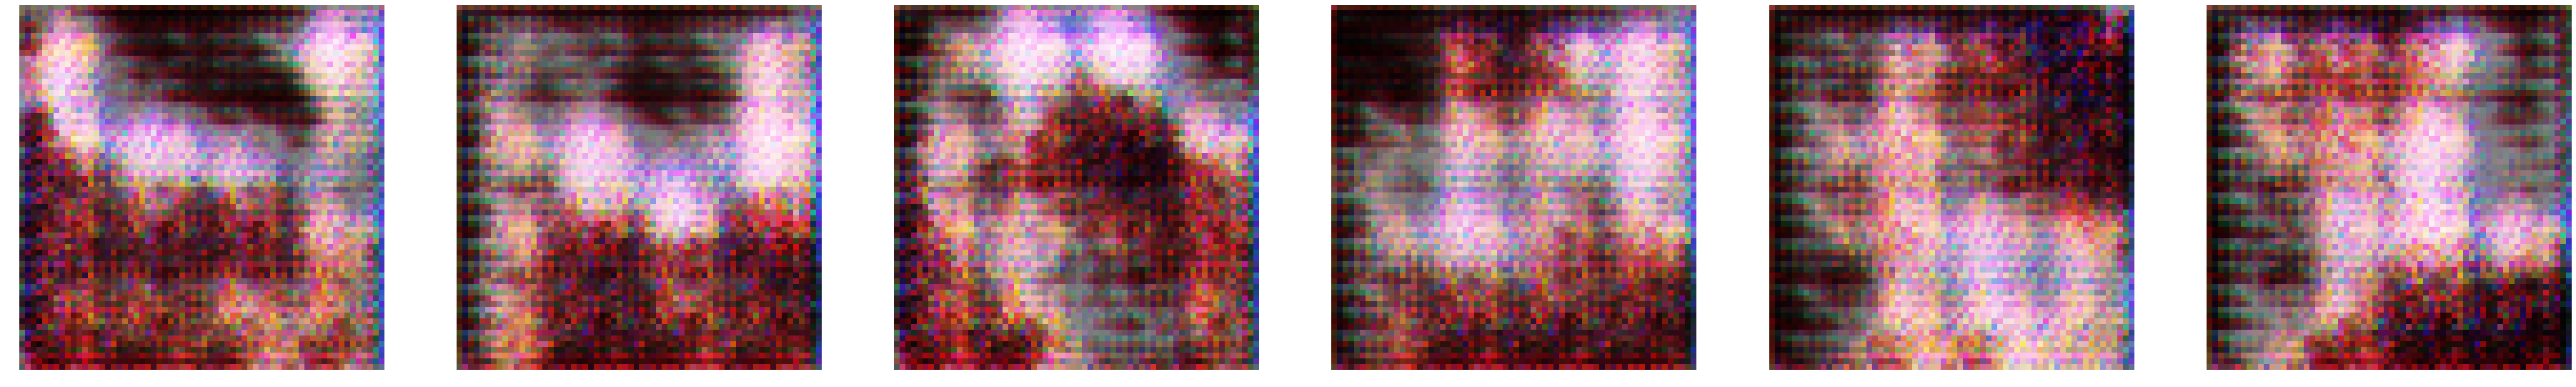

loss=rals 1epochの中での平均値 
 38.08s [2/301] Loss_D: 0.1643 Loss_G: 3.5839 outputR: -2.4475 outputF: -3.1619 / -3.4455
  最後のバッチのloss等 
    38.08s [2/301] Loss_D: 0.1190 Loss_G: 4.3795 outputR: -2.7810 outputF: -3.4277 / -3.9825
loss=rals 1epochの中での平均値 
 38.05s [3/301] Loss_D: 0.1309 Loss_G: 3.2602 outputR: -2.4922 outputF: -3.2489 / -3.4102
  最後のバッチのloss等 
    38.05s [3/301] Loss_D: 0.1881 Loss_G: 2.7926 outputR: -1.6749 outputF: -2.8305 / -2.4890
loss=rals 1epochの中での平均値 
 38.03s [4/301] Loss_D: 0.1254 Loss_G: 3.1567 outputR: -1.9129 outputF: -2.6716 / -2.8060
  最後のバッチのloss等 
    38.03s [4/301] Loss_D: 0.1712 Loss_G: 4.0722 outputR: -2.0231 outputF: -2.5238 / -3.1493
loss=rals 1epochの中での平均値 
 38.09s [5/301] Loss_D: 0.1076 Loss_G: 3.0989 outputR: -1.4508 outputF: -2.2319 / -2.3297
  最後のバッチのloss等 
    38.09s [5/301] Loss_D: 0.0766 Loss_G: 3.4209 outputR: -1.3398 outputF: -2.0423 / -2.3247
loss=rals 1epochの中での平均値 
 38.03s [6/301] Loss_D: 0.1270 Loss_G: 3.2579 outputR: -1.2946 outputF: -2.0513

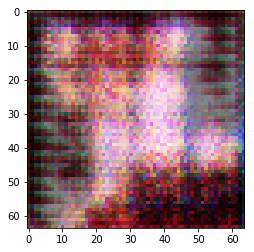

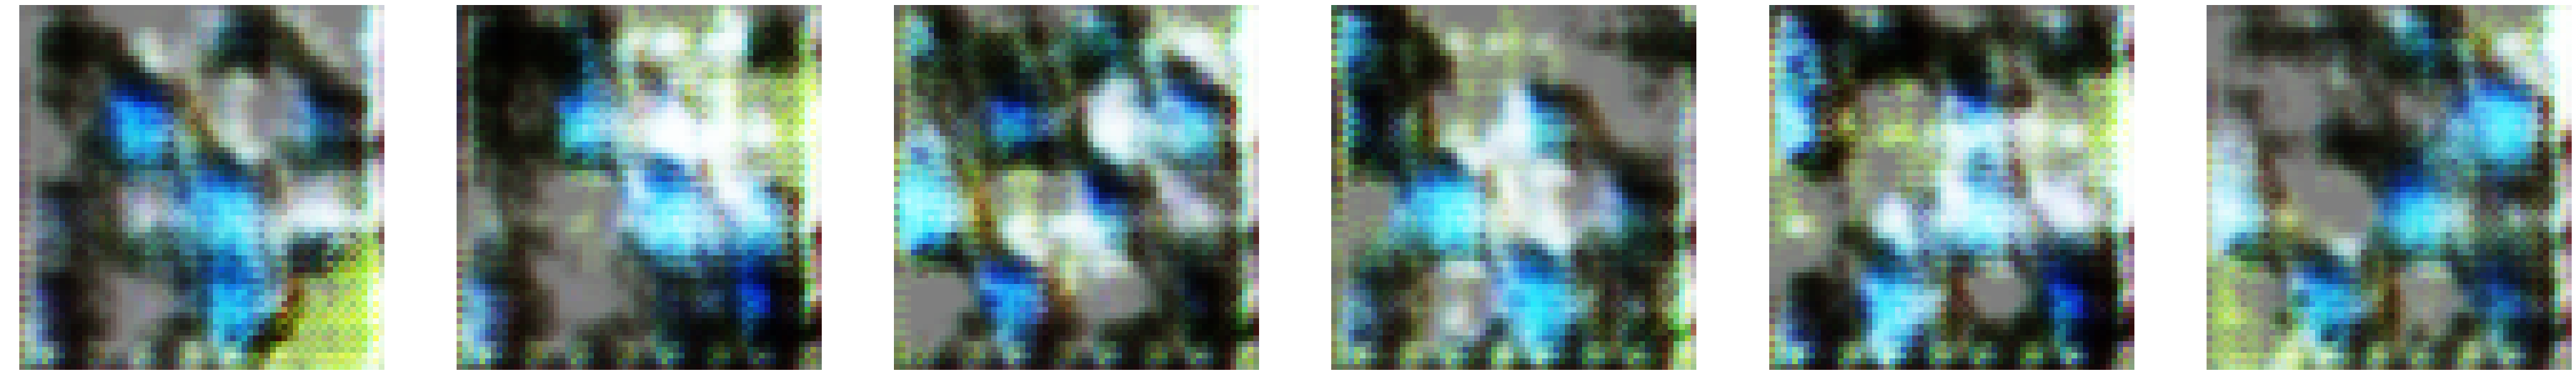

loss=rals 1epochの中での平均値 
 38.13s [12/301] Loss_D: 0.1121 Loss_G: 3.3544 outputR: -0.4159 outputF: -1.1855 / -1.3611
  最後のバッチのloss等 
    38.13s [12/301] Loss_D: 0.0924 Loss_G: 3.8390 outputR: -0.3729 outputF: -1.2235 / -1.4754
loss=rals 1epochの中での平均値 
 38.02s [13/301] Loss_D: 0.1427 Loss_G: 3.2656 outputR: -0.7318 outputF: -1.4701 / -1.6522
  最後のバッチのloss等 
    38.02s [13/301] Loss_D: 0.0511 Loss_G: 3.2893 outputR: -1.0822 outputF: -2.0320 / -2.0128
loss=rals 1epochの中での平均値 
 38.16s [14/301] Loss_D: 0.1086 Loss_G: 3.1366 outputR: -0.5748 outputF: -1.3471 / -1.4635
  最後のバッチのloss等 
    38.16s [14/301] Loss_D: 0.1840 Loss_G: 2.8739 outputR: -1.6148 outputF: -2.1616 / -2.4292
loss=rals 1epochの中での平均値 
 38.47s [15/301] Loss_D: 0.1148 Loss_G: 3.1967 outputR: -0.4110 outputF: -1.1780 / -1.3169
  最後のバッチのloss等 
    38.47s [15/301] Loss_D: 0.0521 Loss_G: 3.4543 outputR: -0.5283 outputF: -1.2399 / -1.4766
loss=rals 1epochの中での平均値 
 38.21s [16/301] Loss_D: 0.0807 Loss_G: 3.0351 outputR: -0.4901 outputF

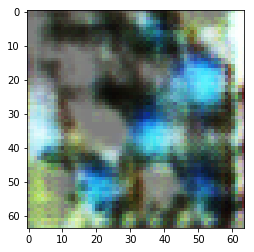

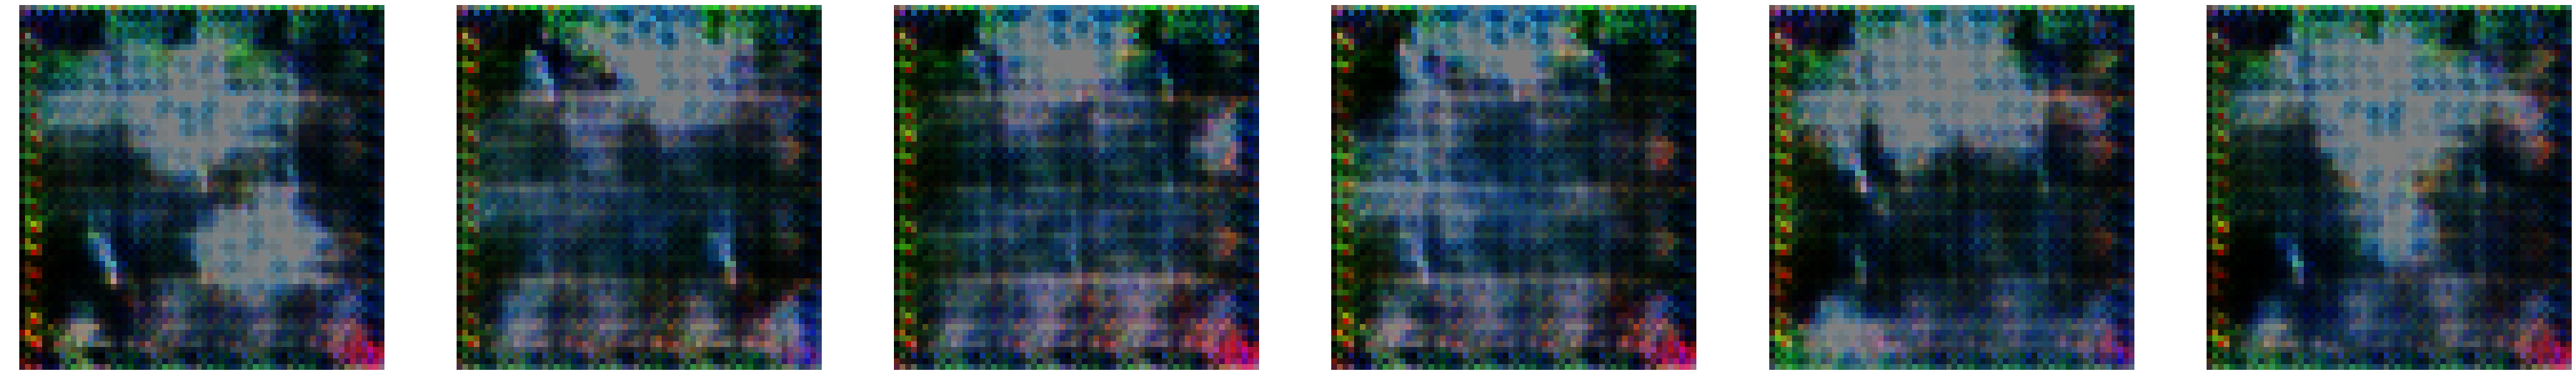

loss=rals 1epochの中での平均値 
 38.12s [22/301] Loss_D: 0.0376 Loss_G: 3.0175 outputR: -0.1940 outputF: -1.0504 / -1.0579
  最後のバッチのloss等 
    38.12s [22/301] Loss_D: 0.0549 Loss_G: 2.8223 outputR: -0.2714 outputF: -1.0966 / -1.1028
loss=rals 1epochの中での平均値 
 38.42s [23/301] Loss_D: 0.0362 Loss_G: 3.0137 outputR: -0.1690 outputF: -1.0272 / -1.0319
  最後のバッチのloss等 
    38.42s [23/301] Loss_D: 0.0624 Loss_G: 2.8962 outputR: -0.0850 outputF: -1.0008 / -0.9461
loss=rals 1epochの中での平均値 
 38.33s [24/301] Loss_D: 0.0427 Loss_G: 3.0564 outputR: -0.0552 outputF: -0.9045 / -0.9292
  最後のバッチのloss等 
    38.33s [24/301] Loss_D: 0.0602 Loss_G: 2.6936 outputR: 0.0467 outputF: -0.8565 / -0.7575
loss=rals 1epochの中での平均値 
 38.13s [25/301] Loss_D: 0.0890 Loss_G: 3.2179 outputR: -0.1446 outputF: -0.9343 / -1.0566
  最後のバッチのloss等 
    38.13s [25/301] Loss_D: 0.0718 Loss_G: 3.1740 outputR: -0.3974 outputF: -1.3220 / -1.3284
loss=rals 1epochの中での平均値 
 38.23s [26/301] Loss_D: 0.0763 Loss_G: 3.0837 outputR: -0.0077 outputF:

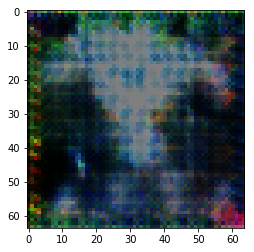

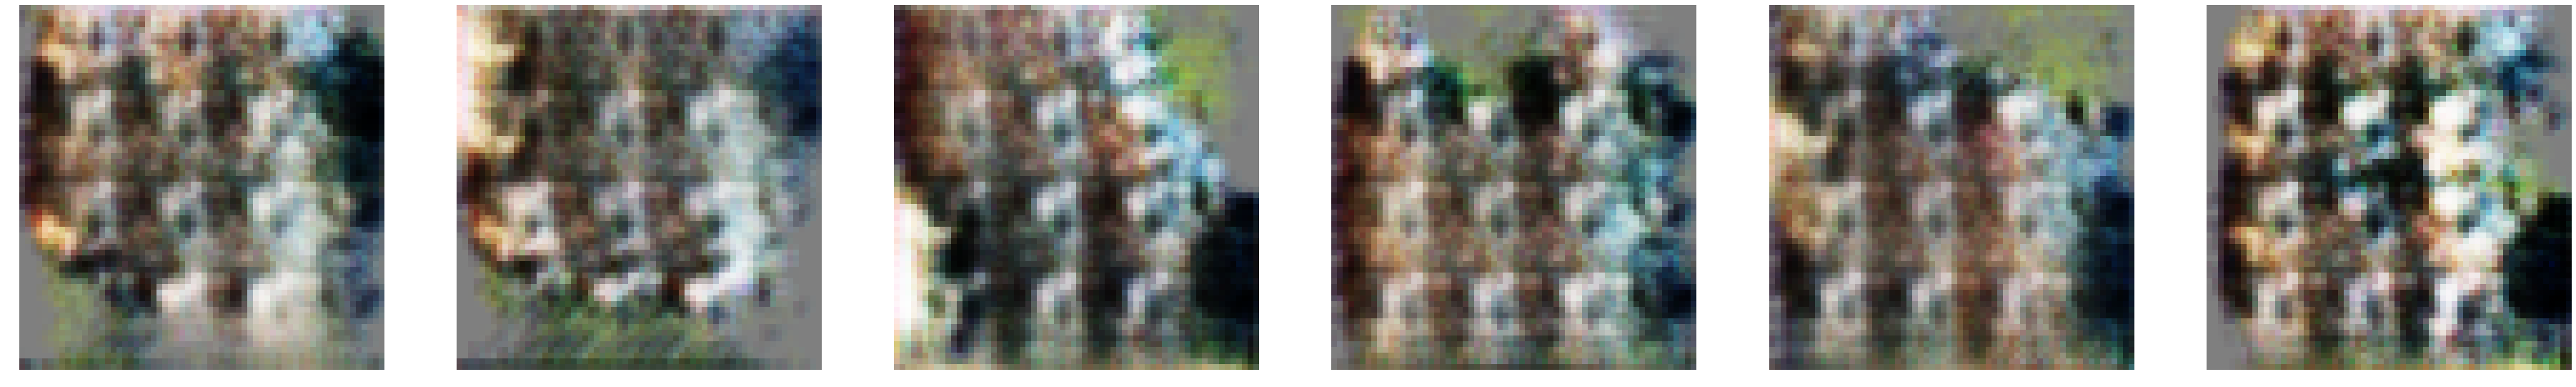

loss=rals 1epochの中での平均値 
 38.39s [32/301] Loss_D: 0.0676 Loss_G: 3.0395 outputR: -0.4118 outputF: -1.2270 / -1.2776
  最後のバッチのloss等 
    38.39s [32/301] Loss_D: 0.0277 Loss_G: 3.2515 outputR: -0.4362 outputF: -1.3932 / -1.3506
loss=rals 1epochの中での平均値 
 38.15s [33/301] Loss_D: 0.0680 Loss_G: 3.0046 outputR: -0.5220 outputF: -1.3369 / -1.3778
  最後のバッチのloss等 
    38.15s [33/301] Loss_D: 0.0247 Loss_G: 3.0234 outputR: -0.5543 outputF: -1.3940 / -1.4112
loss=rals 1epochの中での平均値 
 38.11s [34/301] Loss_D: 0.0763 Loss_G: 3.0022 outputR: -0.5230 outputF: -1.3328 / -1.3794
  最後のバッチのloss等 
    38.11s [34/301] Loss_D: 0.0599 Loss_G: 2.8180 outputR: -0.4676 outputF: -1.1619 / -1.2555
loss=rals 1epochの中での平均値 
 38.15s [35/301] Loss_D: 0.0660 Loss_G: 3.0285 outputR: -0.5541 outputF: -1.3744 / -1.4179
  最後のバッチのloss等 
    38.15s [35/301] Loss_D: 0.1006 Loss_G: 3.1707 outputR: -0.9300 outputF: -1.5532 / -1.8385
loss=rals 1epochの中での平均値 
 38.15s [36/301] Loss_D: 0.0708 Loss_G: 3.0334 outputR: -0.5927 outputF

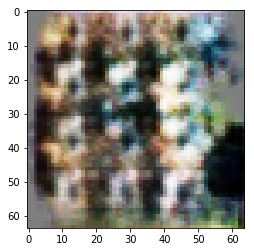

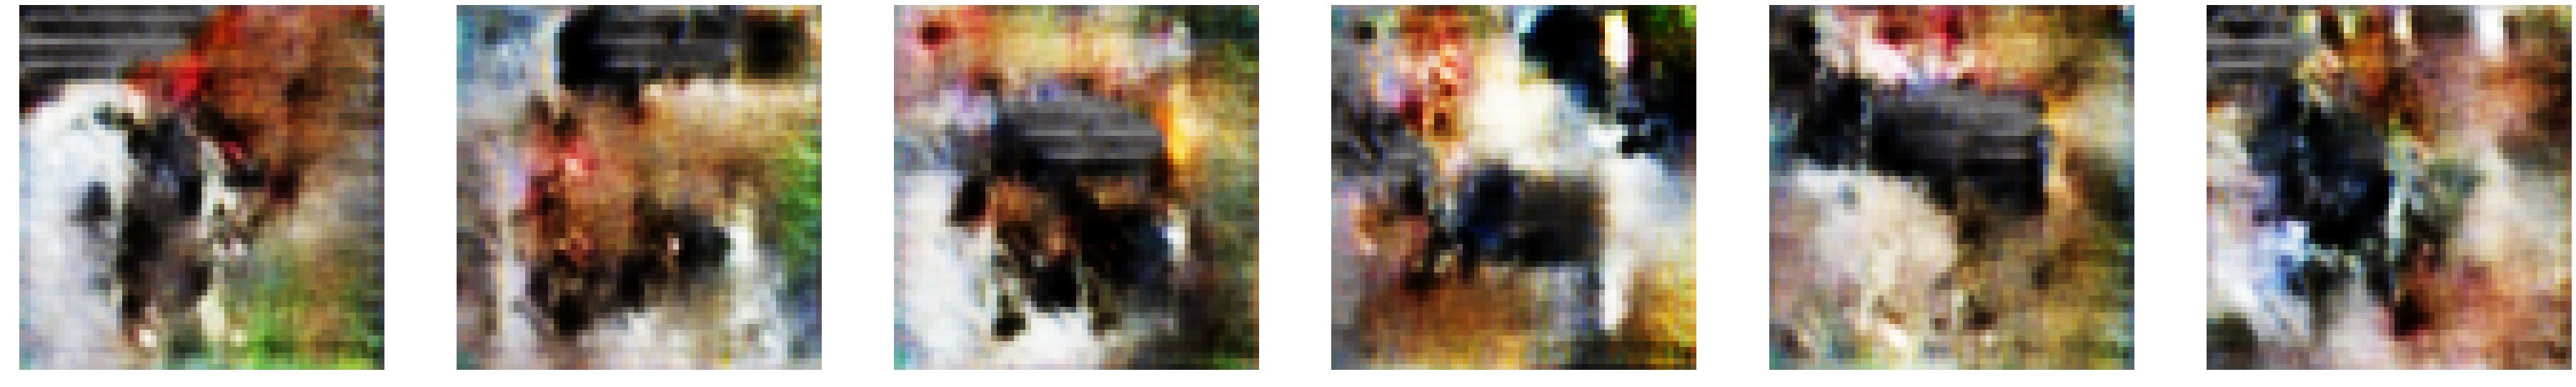

loss=rals 1epochの中での平均値 
 38.08s [42/301] Loss_D: 0.0818 Loss_G: 3.0972 outputR: -0.9635 outputF: -1.7666 / -1.8444
  最後のバッチのloss等 
    38.08s [42/301] Loss_D: 0.0985 Loss_G: 2.5248 outputR: -1.3430 outputF: -1.9878 / -2.0705
loss=rals 1epochの中での平均値 
 38.17s [43/301] Loss_D: 0.0862 Loss_G: 3.0939 outputR: -0.9970 outputF: -1.7962 / -1.8768
  最後のバッチのloss等 
    38.17s [43/301] Loss_D: 0.0568 Loss_G: 3.3083 outputR: -1.0879 outputF: -1.9886 / -2.0305
loss=rals 1epochの中での平均値 
 38.19s [44/301] Loss_D: 0.0788 Loss_G: 3.1046 outputR: -0.8153 outputF: -1.6214 / -1.6971
  最後のバッチのloss等 
    38.19s [44/301] Loss_D: 0.0400 Loss_G: 3.1542 outputR: -1.1785 outputF: -1.9079 / -2.0440
loss=rals 1epochの中での平均値 
 38.08s [45/301] Loss_D: 0.0777 Loss_G: 3.0823 outputR: -0.7722 outputF: -1.5803 / -1.6494
  最後のバッチのloss等 
    38.08s [45/301] Loss_D: 0.0273 Loss_G: 3.7559 outputR: -0.7940 outputF: -1.7856 / -1.8225
loss=rals 1epochの中での平均値 
 38.12s [46/301] Loss_D: 0.0654 Loss_G: 3.0199 outputR: -0.8815 outputF

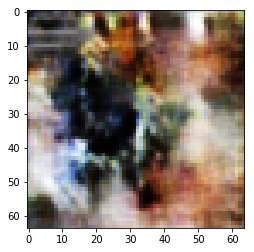

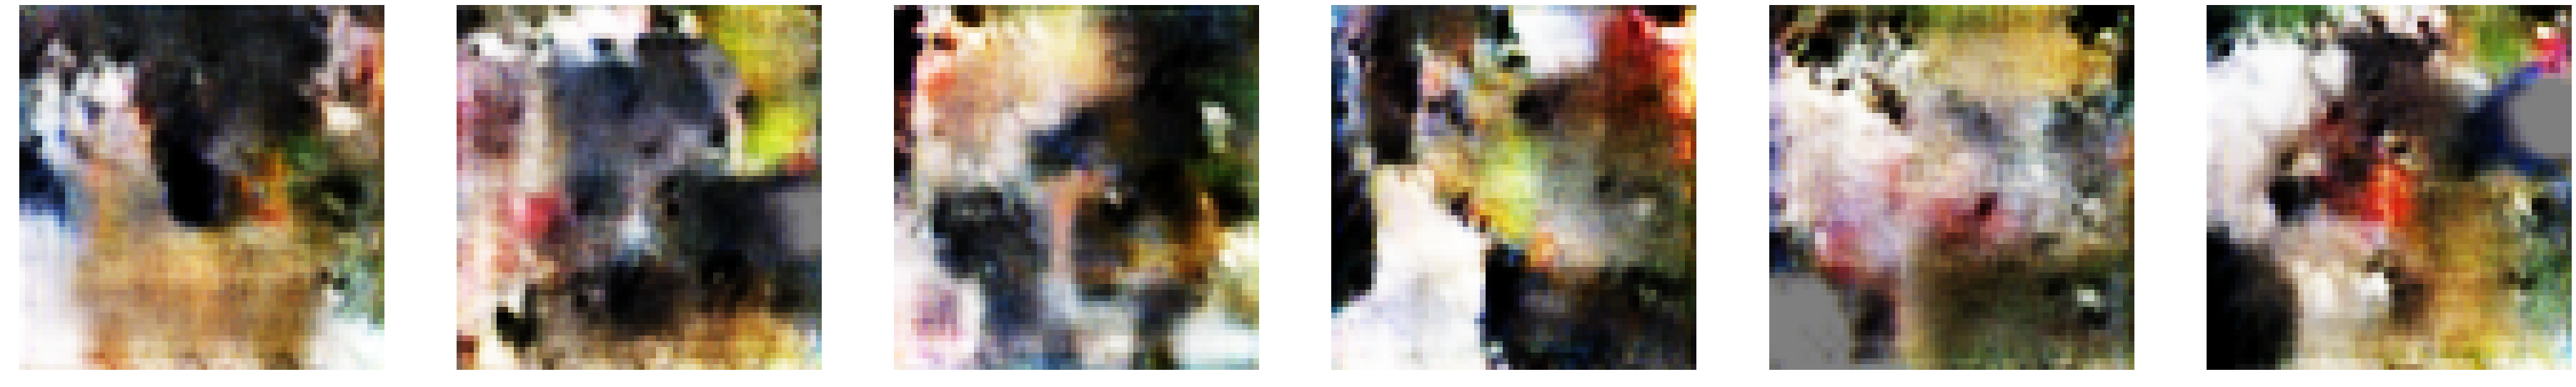

loss=rals 1epochの中での平均値 
 38.09s [52/301] Loss_D: 0.0697 Loss_G: 3.0563 outputR: -0.6913 outputF: -1.5070 / -1.5623
  最後のバッチのloss等 
    38.09s [52/301] Loss_D: 0.0506 Loss_G: 3.2933 outputR: -0.7131 outputF: -1.7188 / -1.6480
loss=rals 1epochの中での平均値 
 38.23s [53/301] Loss_D: 0.0719 Loss_G: 3.0604 outputR: -0.7377 outputF: -1.5495 / -1.6105
  最後のバッチのloss等 
    38.23s [53/301] Loss_D: 0.1308 Loss_G: 3.1974 outputR: -0.4528 outputF: -1.5814 / -1.3695
loss=rals 1epochの中での平均値 
 38.16s [54/301] Loss_D: 0.0754 Loss_G: 3.0837 outputR: -0.7181 outputF: -1.5274 / -1.5957
  最後のバッチのloss等 
    38.16s [54/301] Loss_D: 0.0117 Loss_G: 3.5204 outputR: -0.5841 outputF: -1.4916 / -1.5483
loss=rals 1epochの中での平均値 
 38.46s [55/301] Loss_D: 0.0749 Loss_G: 3.0930 outputR: -0.7628 outputF: -1.5734 / -1.6440
  最後のバッチのloss等 
    38.46s [55/301] Loss_D: 0.0469 Loss_G: 3.2324 outputR: -0.5694 outputF: -1.5587 / -1.4807
loss=rals 1epochの中での平均値 
 38.44s [56/301] Loss_D: 0.0731 Loss_G: 3.0766 outputR: -0.7224 outputF

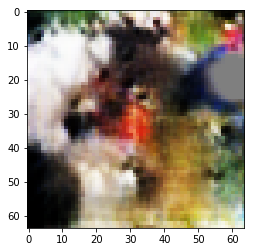

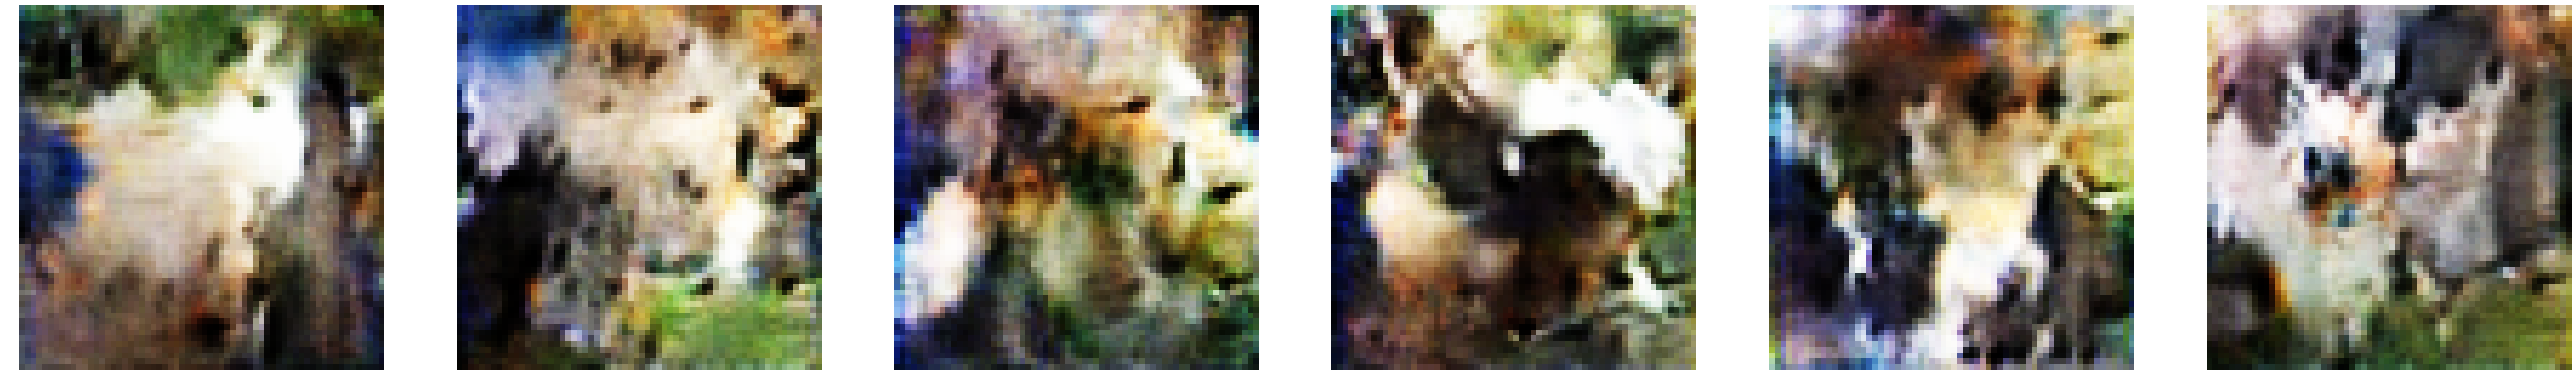

loss=rals 1epochの中での平均値 
 38.13s [62/301] Loss_D: 0.0680 Loss_G: 3.0068 outputR: -0.7707 outputF: -1.5852 / -1.6277
  最後のバッチのloss等 
    38.13s [62/301] Loss_D: 0.0172 Loss_G: 3.2120 outputR: -0.8055 outputF: -1.6634 / -1.6966
loss=rals 1epochの中での平均値 
 38.31s [63/301] Loss_D: 0.0678 Loss_G: 3.0283 outputR: -0.7722 outputF: -1.5885 / -1.6346
  最後のバッチのloss等 
    38.31s [63/301] Loss_D: 0.0618 Loss_G: 2.9944 outputR: -0.8839 outputF: -1.5675 / -1.7100
loss=rals 1epochの中での平均値 
 38.31s [64/301] Loss_D: 0.0708 Loss_G: 3.0314 outputR: -0.7080 outputF: -1.5220 / -1.5715
  最後のバッチのloss等 
    38.31s [64/301] Loss_D: 0.0293 Loss_G: 2.9382 outputR: -1.0201 outputF: -1.7909 / -1.8352
loss=rals 1epochの中での平均値 
 38.05s [65/301] Loss_D: 0.0704 Loss_G: 3.0327 outputR: -0.8171 outputF: -1.6302 / -1.6814
  最後のバッチのloss等 
    38.05s [65/301] Loss_D: 0.0482 Loss_G: 2.9336 outputR: -1.1337 outputF: -1.8915 / -1.9659
loss=rals 1epochの中での平均値 
 38.10s [66/301] Loss_D: 0.0695 Loss_G: 3.0468 outputR: -0.8312 outputF

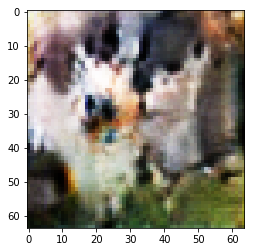

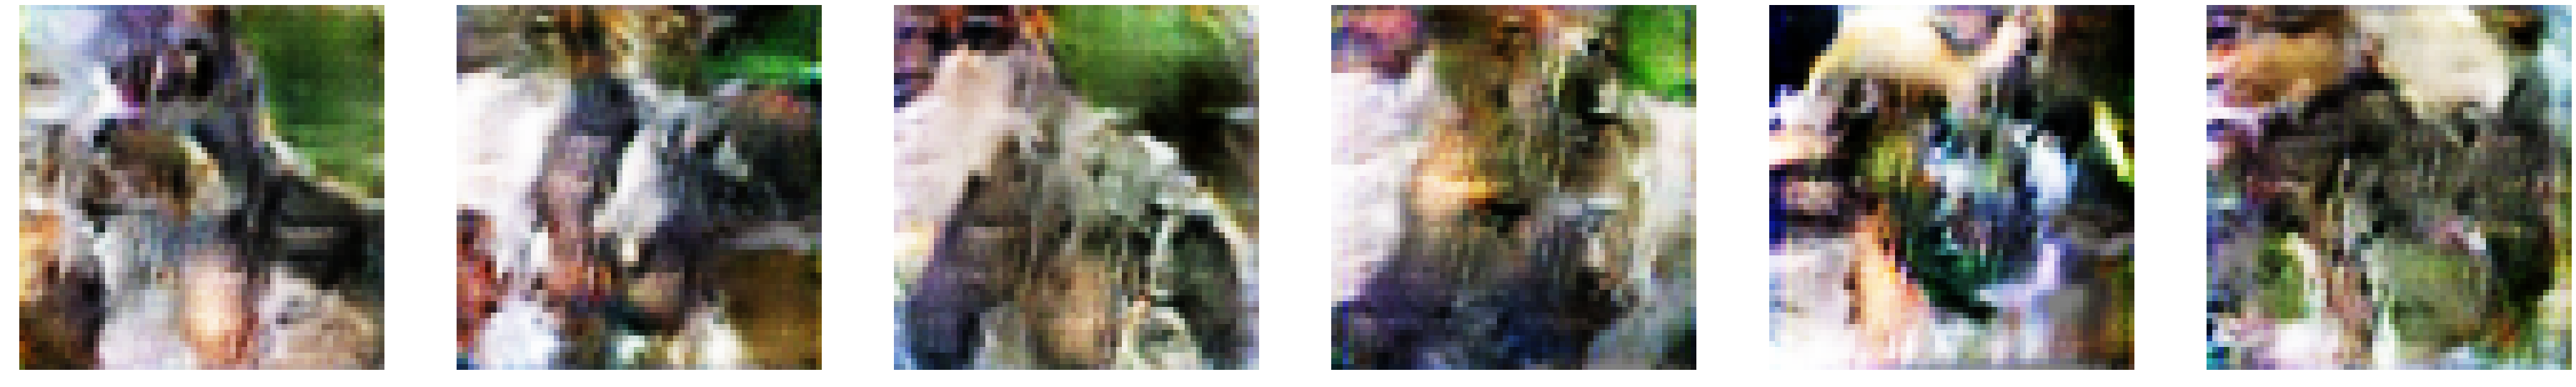

loss=rals 1epochの中での平均値 
 38.14s [72/301] Loss_D: 0.0799 Loss_G: 3.0670 outputR: -0.7302 outputF: -1.5317 / -1.6029
  最後のバッチのloss等 
    38.14s [72/301] Loss_D: 0.0763 Loss_G: 2.9275 outputR: -0.6234 outputF: -1.6477 / -1.4625
loss=rals 1epochの中での平均値 
 38.03s [73/301] Loss_D: 0.0787 Loss_G: 3.0719 outputR: -0.7443 outputF: -1.5472 / -1.6186
  最後のバッチのloss等 
    38.03s [73/301] Loss_D: 0.0655 Loss_G: 2.8975 outputR: -0.6218 outputF: -1.3416 / -1.4546
loss=rals 1epochの中での平均値 
 37.90s [74/301] Loss_D: 0.0796 Loss_G: 3.0889 outputR: -0.7812 outputF: -1.5852 / -1.6598
  最後のバッチのloss等 
    37.90s [74/301] Loss_D: 0.1389 Loss_G: 2.9654 outputR: -0.5792 outputF: -1.6570 / -1.4470
loss=rals 1epochの中での平均値 
 38.00s [75/301] Loss_D: 0.0843 Loss_G: 3.0792 outputR: -0.6819 outputF: -1.4816 / -1.5575
  最後のバッチのloss等 
    38.00s [75/301] Loss_D: 0.1076 Loss_G: 2.8430 outputR: -0.8668 outputF: -1.5169 / -1.7056
loss=rals 1epochの中での平均値 
 38.03s [76/301] Loss_D: 0.0704 Loss_G: 2.9855 outputR: -0.8335 outputF

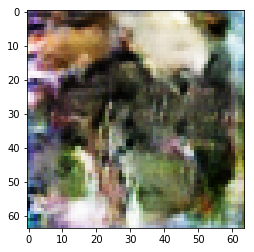

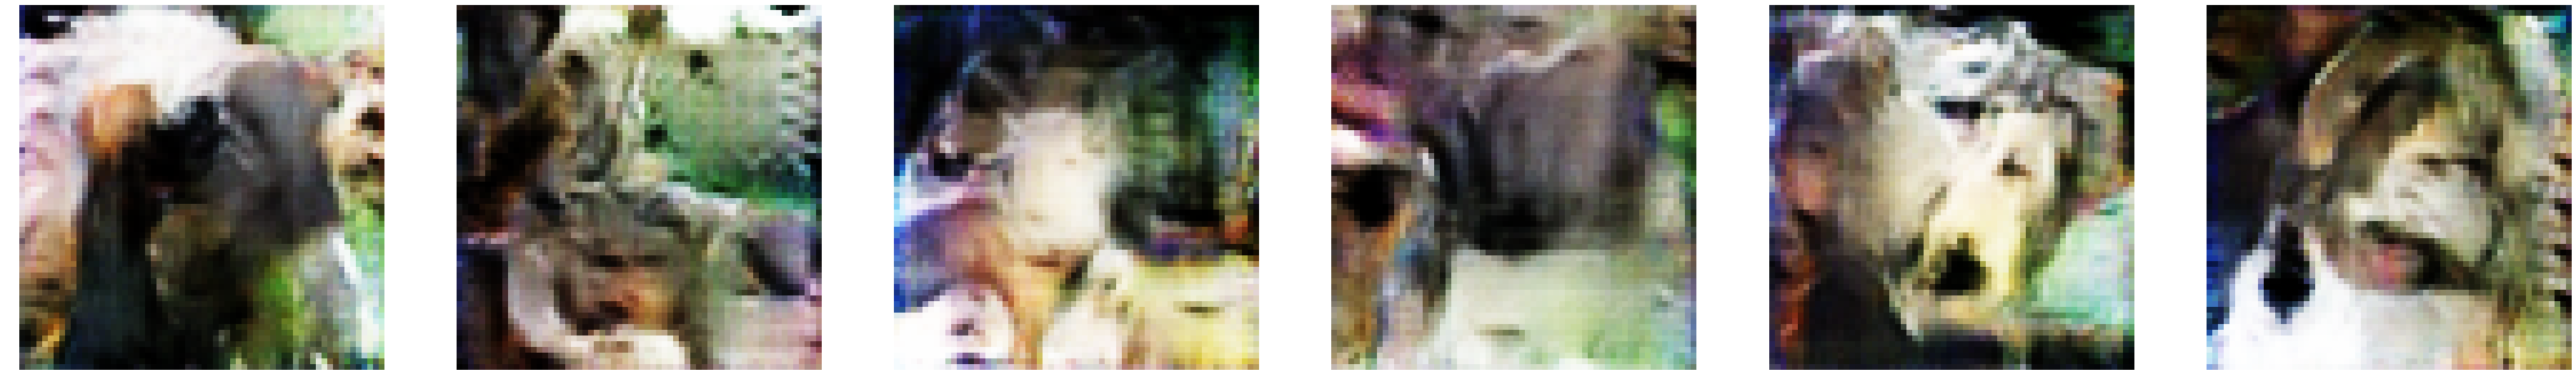

loss=rals 1epochの中での平均値 
 37.86s [82/301] Loss_D: 0.0755 Loss_G: 3.0221 outputR: -0.7164 outputF: -1.5249 / -1.5782
  最後のバッチのloss等 
    37.86s [82/301] Loss_D: 0.0631 Loss_G: 2.9107 outputR: -0.7500 outputF: -1.6079 / -1.5960
loss=rals 1epochの中での平均値 
 37.99s [83/301] Loss_D: 0.0753 Loss_G: 3.0305 outputR: -0.6130 outputF: -1.4224 / -1.4764
  最後のバッチのloss等 
    37.99s [83/301] Loss_D: 0.0422 Loss_G: 3.0757 outputR: -0.6532 outputF: -1.6060 / -1.5155
loss=rals 1epochの中での平均値 
 37.96s [84/301] Loss_D: 0.0753 Loss_G: 3.0424 outputR: -0.7323 outputF: -1.5422 / -1.5987
  最後のバッチのloss等 
    37.96s [84/301] Loss_D: 0.0788 Loss_G: 2.7751 outputR: -0.7302 outputF: -1.5236 / -1.5461
loss=rals 1epochの中での平均値 
 37.97s [85/301] Loss_D: 0.0780 Loss_G: 3.0499 outputR: -0.6513 outputF: -1.4570 / -1.5194
  最後のバッチのloss等 
    37.97s [85/301] Loss_D: 0.0335 Loss_G: 3.0395 outputR: -0.4115 outputF: -1.2423 / -1.2660
loss=rals 1epochの中での平均値 
 38.04s [86/301] Loss_D: 0.0765 Loss_G: 3.0465 outputR: -0.6817 outputF

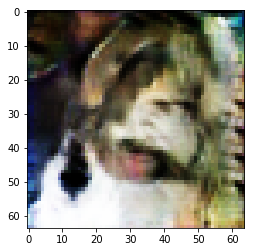

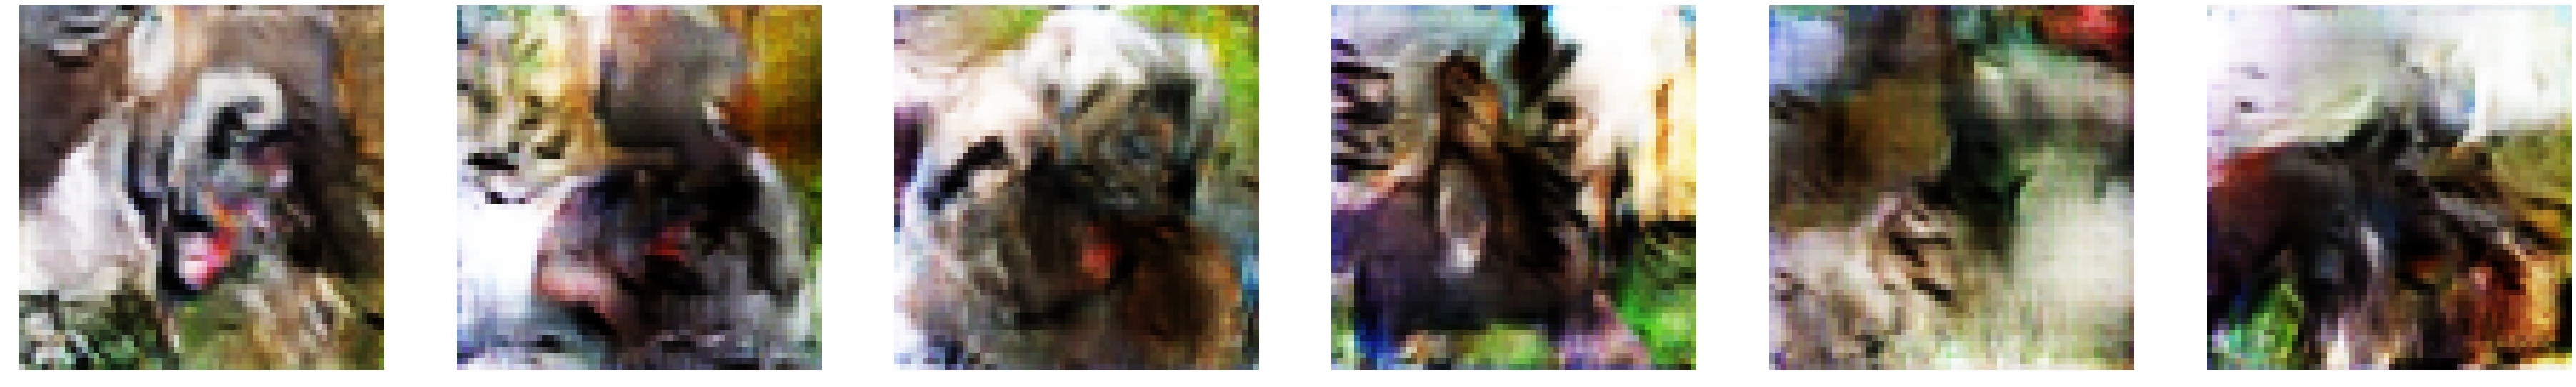

loss=rals 1epochの中での平均値 
 38.02s [92/301] Loss_D: 0.0676 Loss_G: 2.9960 outputR: -0.5685 outputF: -1.3853 / -1.4224
  最後のバッチのloss等 
    38.02s [92/301] Loss_D: 0.0344 Loss_G: 3.3304 outputR: -0.7302 outputF: -1.6927 / -1.6683
loss=rals 1epochの中での平均値 
 37.93s [93/301] Loss_D: 0.0672 Loss_G: 3.0090 outputR: -0.6442 outputF: -1.4616 / -1.5008
  最後のバッチのloss等 
    37.93s [93/301] Loss_D: 0.0179 Loss_G: 3.2468 outputR: -0.4088 outputF: -1.3676 / -1.3081
loss=rals 1epochの中での平均値 
 38.21s [94/301] Loss_D: 0.0657 Loss_G: 3.0117 outputR: -0.6796 outputF: -1.4997 / -1.5376
  最後のバッチのloss等 
    38.21s [94/301] Loss_D: 0.0096 Loss_G: 3.1926 outputR: -0.5463 outputF: -1.4451 / -1.4316
loss=rals 1epochの中での平均値 
 38.08s [95/301] Loss_D: 0.0688 Loss_G: 3.0208 outputR: -0.6123 outputF: -1.4291 / -1.4723
  最後のバッチのloss等 
    38.08s [95/301] Loss_D: 0.0993 Loss_G: 2.5385 outputR: -0.6234 outputF: -1.7018 / -1.3397
loss=rals 1epochの中での平均値 
 37.95s [96/301] Loss_D: 0.0707 Loss_G: 3.0026 outputR: -0.7074 outputF

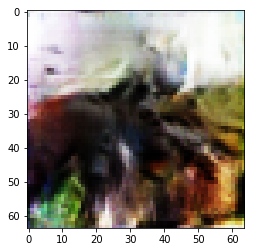

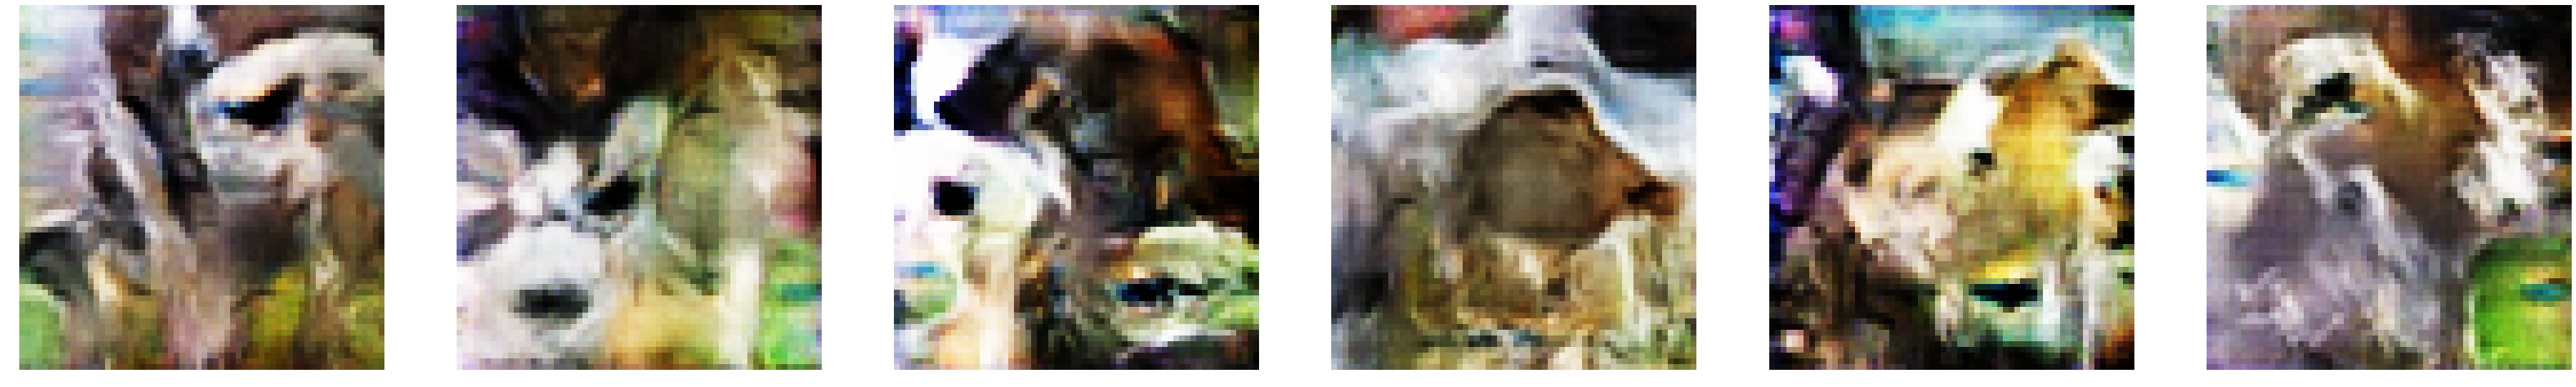

loss=rals 1epochの中での平均値 
 38.32s [102/301] Loss_D: 0.0779 Loss_G: 3.0304 outputR: -0.5326 outputF: -1.3385 / -1.3970
  最後のバッチのloss等 
    38.32s [102/301] Loss_D: 0.1094 Loss_G: 2.8931 outputR: -0.5096 outputF: -1.5119 / -1.3747
loss=rals 1epochの中での平均値 
 38.02s [103/301] Loss_D: 0.0759 Loss_G: 3.0656 outputR: -0.5206 outputF: -1.3307 / -1.3939
  最後のバッチのloss等 
    38.02s [103/301] Loss_D: 0.1002 Loss_G: 2.8202 outputR: -0.5315 outputF: -1.5065 / -1.3725
loss=rals 1epochの中での平均値 
 38.14s [104/301] Loss_D: 0.0749 Loss_G: 3.0410 outputR: -0.5549 outputF: -1.3664 / -1.4203
  最後のバッチのloss等 
    38.14s [104/301] Loss_D: 0.0739 Loss_G: 2.7385 outputR: -0.3712 outputF: -1.1365 / -1.1777
loss=rals 1epochの中での平均値 
 38.13s [105/301] Loss_D: 0.0717 Loss_G: 3.0692 outputR: -0.5186 outputF: -1.3332 / -1.3916
  最後のバッチのloss等 
    38.13s [105/301] Loss_D: 0.1062 Loss_G: 3.0504 outputR: -0.4808 outputF: -1.0655 / -1.3290
loss=rals 1epochの中での平均値 
 37.96s [106/301] Loss_D: 0.0666 Loss_G: 2.9820 outputR: -0.538

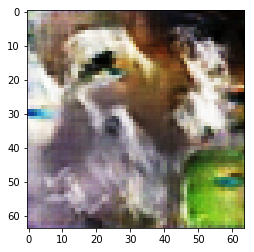

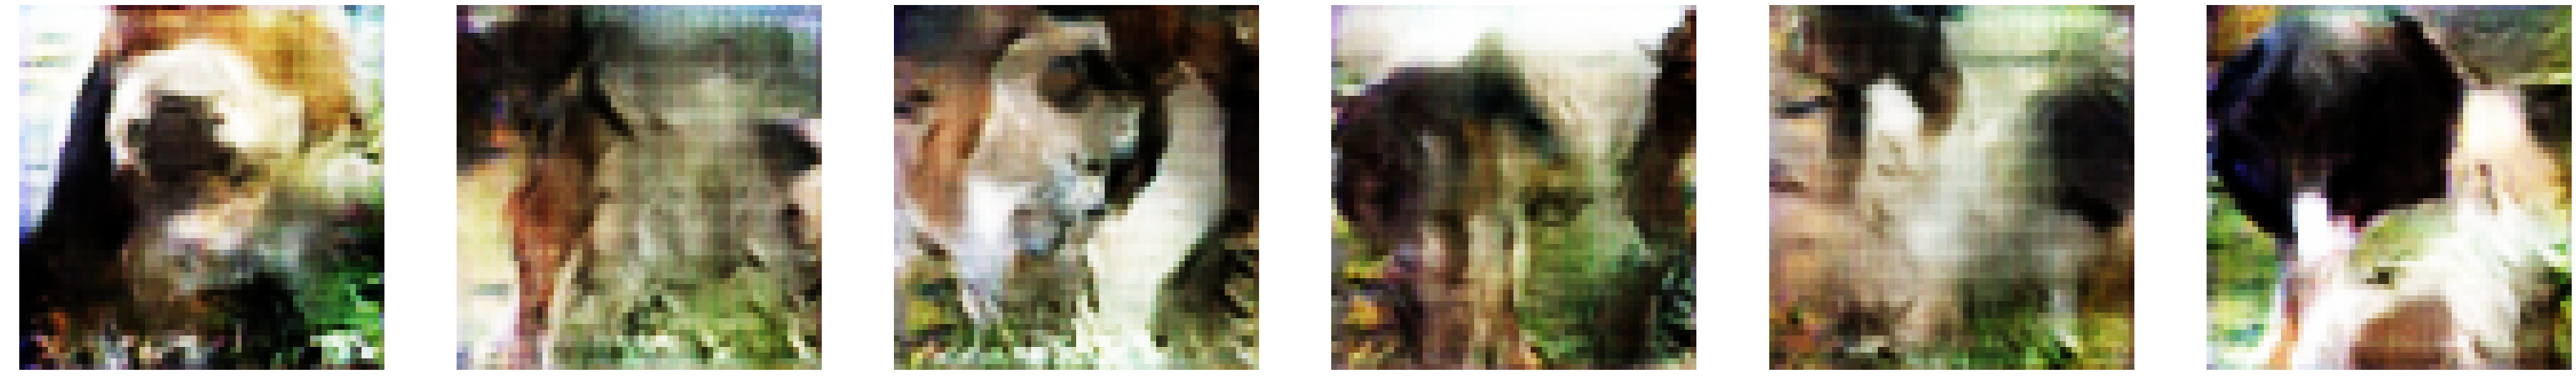

loss=rals 1epochの中での平均値 
 38.00s [112/301] Loss_D: 0.0652 Loss_G: 3.0292 outputR: -0.5193 outputF: -1.3392 / -1.3815
  最後のバッチのloss等 
    38.00s [112/301] Loss_D: 0.0180 Loss_G: 3.2830 outputR: -0.2855 outputF: -1.1321 / -1.1958
loss=rals 1epochの中での平均値 
 38.09s [113/301] Loss_D: 0.0673 Loss_G: 3.0297 outputR: -0.5394 outputF: -1.3593 / -1.4026
  最後のバッチのloss等 
    38.09s [113/301] Loss_D: 0.0162 Loss_G: 3.3521 outputR: -0.3856 outputF: -1.3631 / -1.3076
loss=rals 1epochの中での平均値 
 38.06s [114/301] Loss_D: 0.0687 Loss_G: 3.0346 outputR: -0.4768 outputF: -1.2940 / -1.3416
  最後のバッチのloss等 
    38.06s [114/301] Loss_D: 0.1004 Loss_G: 2.9324 outputR: -0.5355 outputF: -1.1434 / -1.3409
loss=rals 1epochの中での平均値 
 37.98s [115/301] Loss_D: 0.0710 Loss_G: 3.0492 outputR: -0.4715 outputF: -1.2880 / -1.3396
  最後のバッチのloss等 
    37.98s [115/301] Loss_D: 0.0493 Loss_G: 3.0131 outputR: -0.7711 outputF: -1.6279 / -1.6361
loss=rals 1epochの中での平均値 
 37.98s [116/301] Loss_D: 0.0706 Loss_G: 3.0341 outputR: -0.345

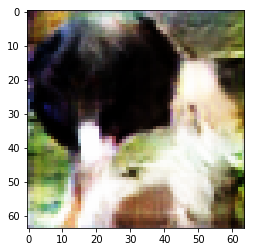

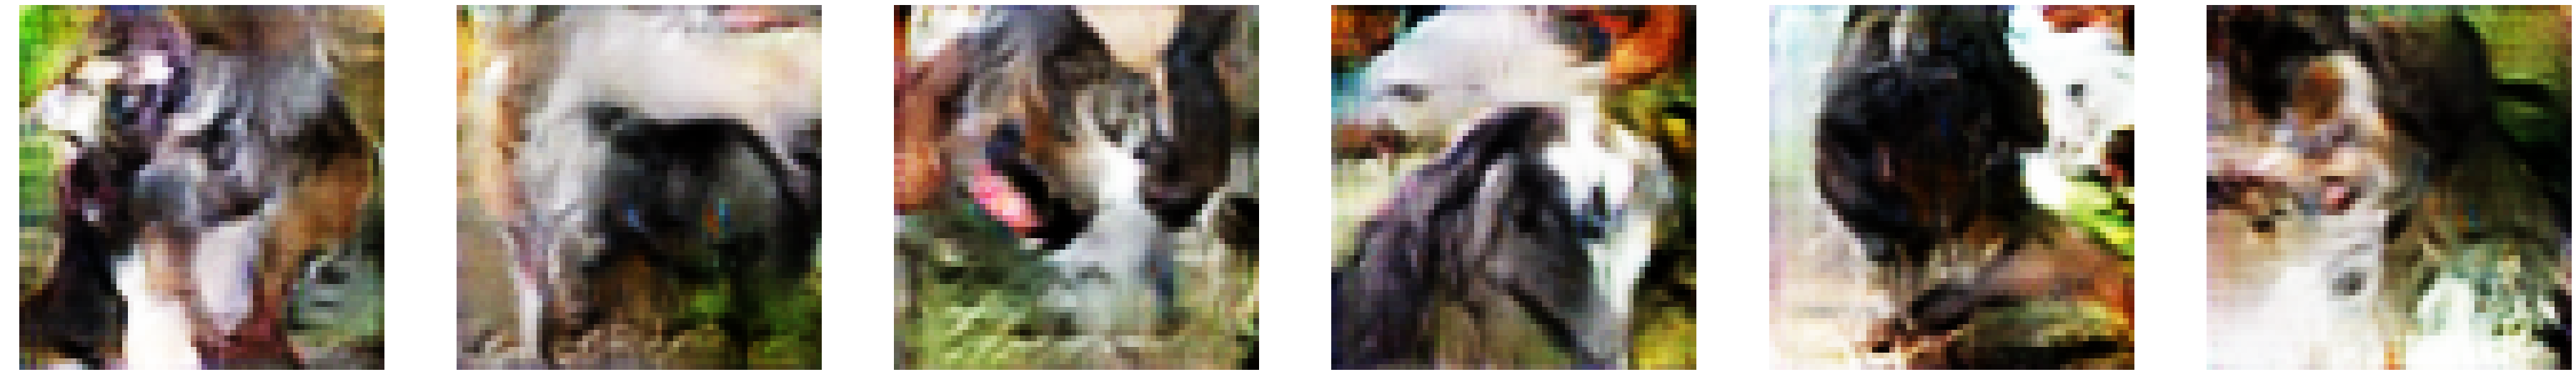

loss=rals 1epochの中での平均値 
 38.00s [122/301] Loss_D: 0.0614 Loss_G: 2.9913 outputR: -0.4931 outputF: -1.3165 / -1.3466
  最後のバッチのloss等 
    38.00s [122/301] Loss_D: 0.0722 Loss_G: 2.5688 outputR: -0.4864 outputF: -1.1979 / -1.2294
loss=rals 1epochの中での平均値 
 37.97s [123/301] Loss_D: 0.0615 Loss_G: 3.0050 outputR: -0.4535 outputF: -1.2792 / -1.3097
  最後のバッチのloss等 
    37.97s [123/301] Loss_D: 0.0543 Loss_G: 2.8408 outputR: -0.3980 outputF: -1.1961 / -1.2348
loss=rals 1epochの中での平均値 
 37.94s [124/301] Loss_D: 0.0617 Loss_G: 3.0217 outputR: -0.4469 outputF: -1.2728 / -1.3071
  最後のバッチのloss等 
    37.94s [124/301] Loss_D: 0.0180 Loss_G: 2.9632 outputR: 0.1684 outputF: -0.6534 / -0.6481
loss=rals 1epochの中での平均値 
 38.00s [125/301] Loss_D: 0.0635 Loss_G: 3.0082 outputR: -0.3621 outputF: -1.1848 / -1.2208
  最後のバッチのloss等 
    38.00s [125/301] Loss_D: 0.0353 Loss_G: 2.9644 outputR: -0.1120 outputF: -1.0403 / -0.9500
loss=rals 1epochの中での平均値 
 38.33s [126/301] Loss_D: 0.0624 Loss_G: 3.0128 outputR: -0.4397

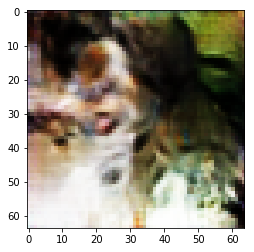

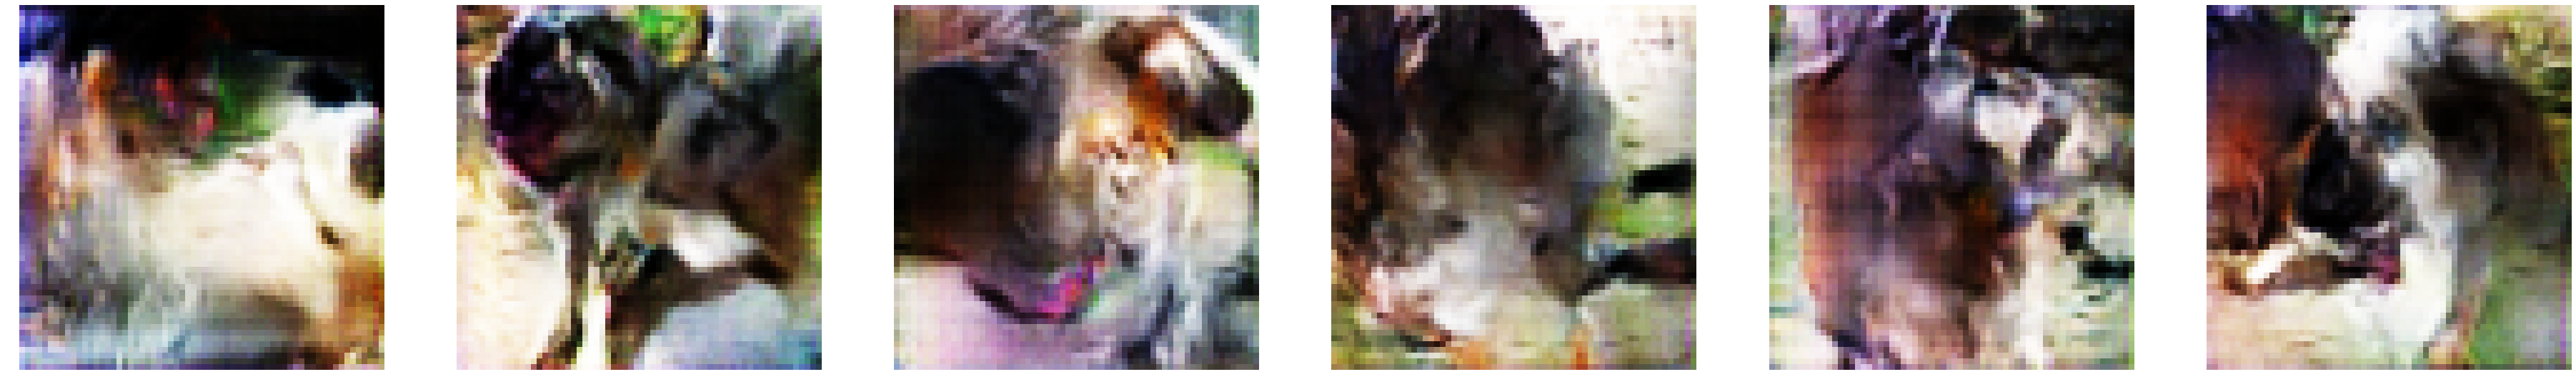

loss=rals 1epochの中での平均値 
 38.10s [132/301] Loss_D: 0.0676 Loss_G: 3.0189 outputR: -0.2759 outputF: -1.0930 / -1.1372
  最後のバッチのloss等 
    38.10s [132/301] Loss_D: 0.1774 Loss_G: 2.4932 outputR: -0.7127 outputF: -1.2421 / -1.4382
loss=rals 1epochの中での平均値 
 37.96s [133/301] Loss_D: 0.0664 Loss_G: 3.0385 outputR: -0.2840 outputF: -1.1045 / -1.1493
  最後のバッチのloss等 
    37.96s [133/301] Loss_D: 0.0144 Loss_G: 2.9574 outputR: -0.4164 outputF: -1.2157 / -1.2422
loss=rals 1epochの中での平均値 
 38.31s [134/301] Loss_D: 0.0717 Loss_G: 3.0367 outputR: -0.2956 outputF: -1.1090 / -1.1608
  最後のバッチのloss等 
    38.31s [134/301] Loss_D: 0.0449 Loss_G: 2.9353 outputR: -0.3202 outputF: -1.1816 / -1.1619
loss=rals 1epochの中での平均値 
 37.96s [135/301] Loss_D: 0.0707 Loss_G: 3.0263 outputR: -0.3694 outputF: -1.1870 / -1.2320
  最後のバッチのloss等 
    37.96s [135/301] Loss_D: 0.1201 Loss_G: 2.6500 outputR: -0.2434 outputF: -1.2664 / -1.0205
loss=rals 1epochの中での平均値 
 37.93s [136/301] Loss_D: 0.0605 Loss_G: 2.9748 outputR: -0.332

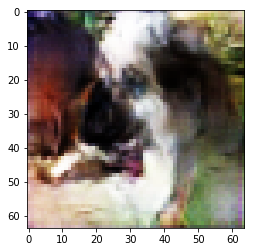

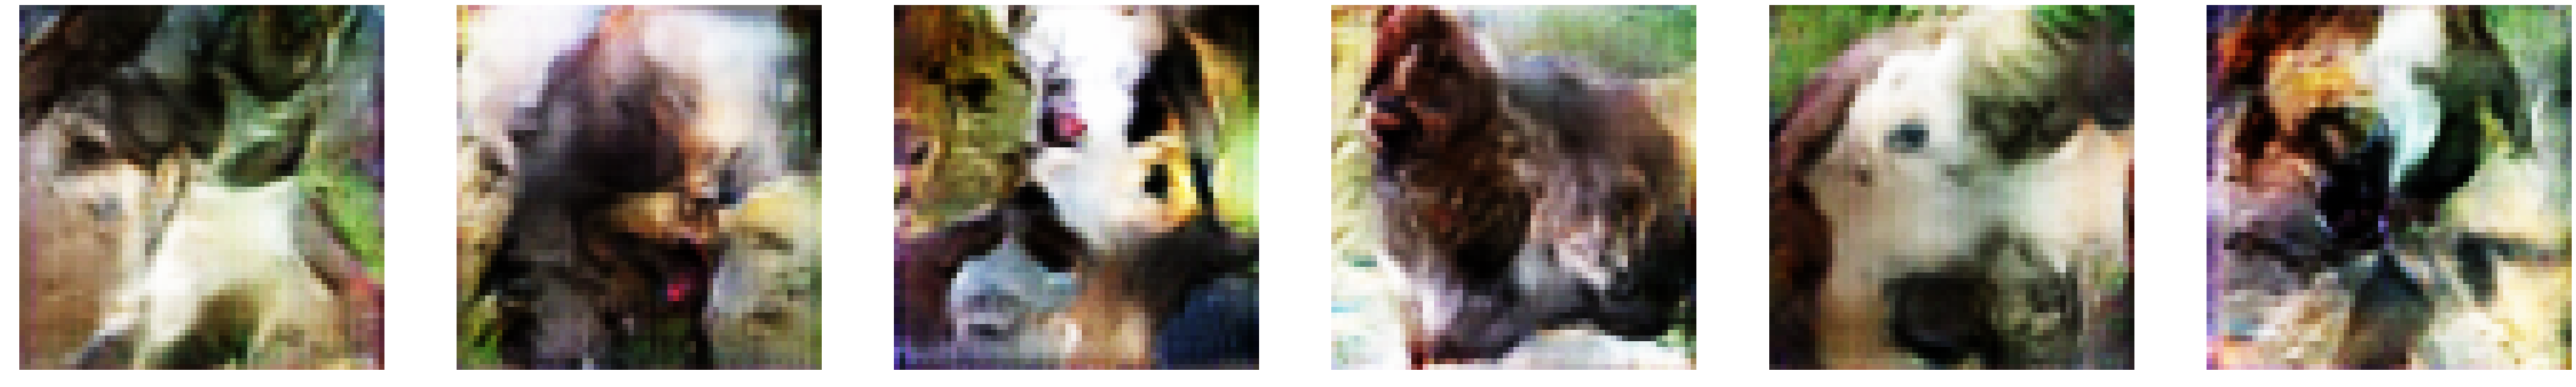

loss=rals 1epochの中での平均値 
 38.44s [142/301] Loss_D: 0.0639 Loss_G: 2.9899 outputR: -0.3134 outputF: -1.1360 / -1.1672
  最後のバッチのloss等 
    38.44s [142/301] Loss_D: 0.1513 Loss_G: 2.0228 outputR: -0.9147 outputF: -1.4350 / -1.4372
loss=rals 1epochの中での平均値 
 38.04s [143/301] Loss_D: 0.0640 Loss_G: 3.0118 outputR: -0.3066 outputF: -1.1314 / -1.1647
  最後のバッチのloss等 
    38.04s [143/301] Loss_D: 0.0754 Loss_G: 2.6760 outputR: 0.0504 outputF: -0.7492 / -0.7468
loss=rals 1epochの中での平均値 
 38.12s [144/301] Loss_D: 0.0637 Loss_G: 3.0083 outputR: -0.2482 outputF: -1.0738 / -1.1060
  最後のバッチのloss等 
    38.12s [144/301] Loss_D: 0.0736 Loss_G: 3.2453 outputR: -0.3728 outputF: -1.3725 / -1.3080
loss=rals 1epochの中での平均値 
 38.10s [145/301] Loss_D: 0.0638 Loss_G: 3.0214 outputR: -0.2668 outputF: -1.0880 / -1.1284
  最後のバッチのloss等 
    38.10s [145/301] Loss_D: 0.0690 Loss_G: 3.1926 outputR: -0.5564 outputF: -1.4541 / -1.4921
loss=rals 1epochの中での平均値 
 38.24s [146/301] Loss_D: 0.0683 Loss_G: 3.0161 outputR: -0.1722

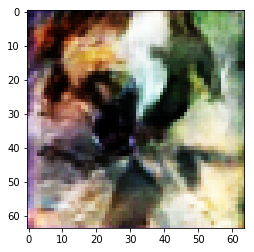

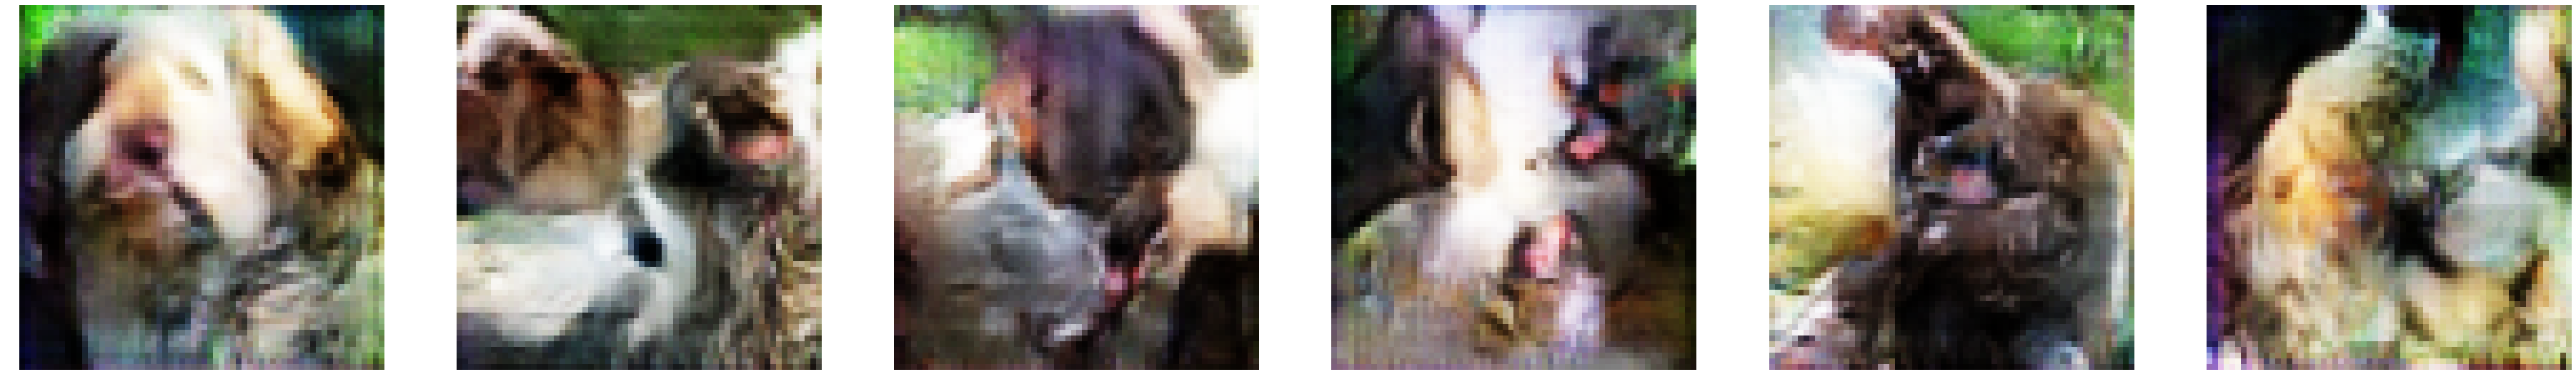

loss=rals 1epochの中での平均値 
 38.11s [152/301] Loss_D: 0.0577 Loss_G: 2.9967 outputR: -0.0817 outputF: -0.9119 / -0.9357
  最後のバッチのloss等 
    38.11s [152/301] Loss_D: 0.0363 Loss_G: 3.3137 outputR: 0.0820 outputF: -0.8555 / -0.8657
loss=rals 1epochの中での平均値 
 38.05s [153/301] Loss_D: 0.0563 Loss_G: 2.9859 outputR: -0.1853 outputF: -1.0150 / -1.0373
  最後のバッチのloss等 
    38.05s [153/301] Loss_D: 0.0534 Loss_G: 2.8394 outputR: -0.1761 outputF: -0.9469 / -0.9880
loss=rals 1epochの中での平均値 
 38.08s [154/301] Loss_D: 0.0588 Loss_G: 2.9889 outputR: -0.1556 outputF: -0.9852 / -1.0091
  最後のバッチのloss等 
    38.08s [154/301] Loss_D: 0.0796 Loss_G: 3.2794 outputR: -0.0656 outputF: -0.9937 / -1.0327
loss=rals 1epochの中での平均値 
 37.99s [155/301] Loss_D: 0.0585 Loss_G: 2.9992 outputR: -0.2102 outputF: -1.0391 / -1.0654
  最後のバッチのloss等 
    37.99s [155/301] Loss_D: 0.0307 Loss_G: 2.9366 outputR: 0.0446 outputF: -0.7898 / -0.7895
loss=rals 1epochの中での平均値 
 38.06s [156/301] Loss_D: 0.0567 Loss_G: 3.0035 outputR: -0.1269 

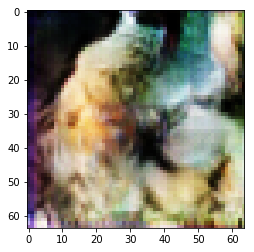

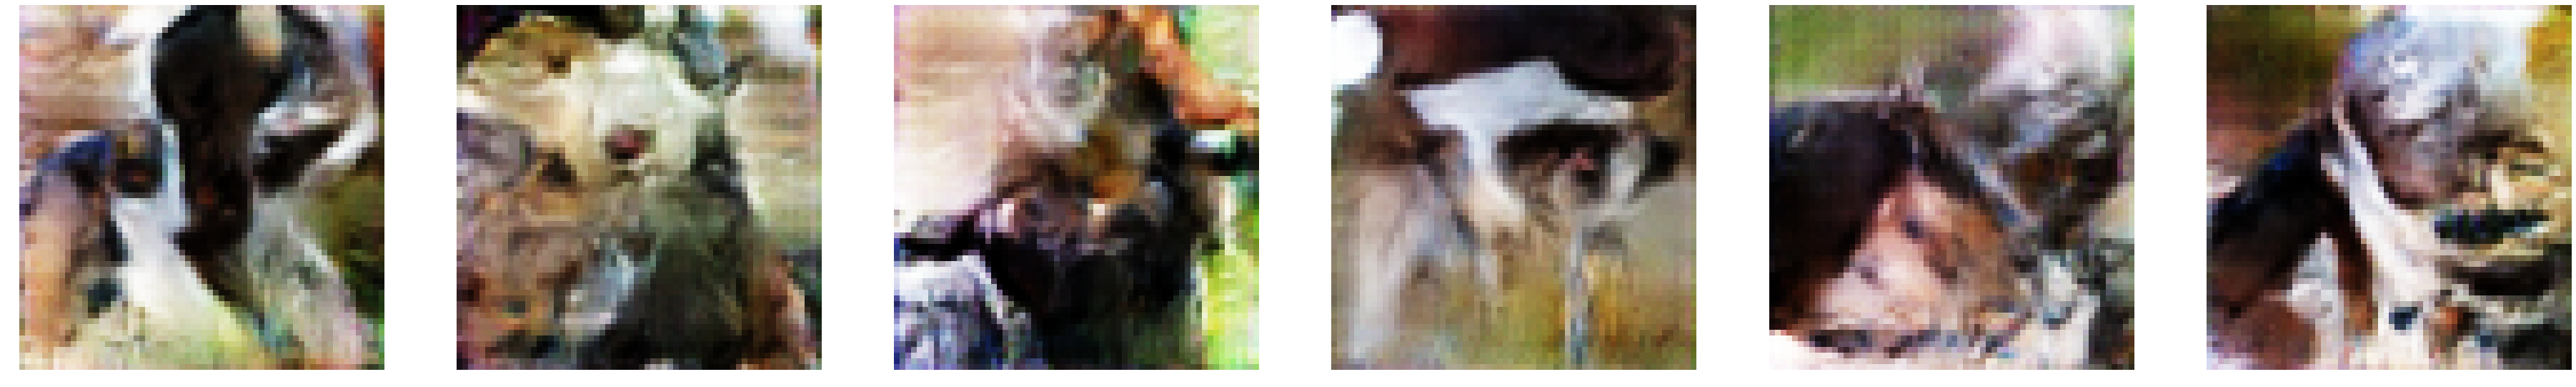

loss=rals 1epochの中での平均値 
 38.15s [162/301] Loss_D: 0.0579 Loss_G: 3.0120 outputR: -0.0627 outputF: -0.8950 / -0.9215
  最後のバッチのloss等 
    38.15s [162/301] Loss_D: 0.0362 Loss_G: 3.2605 outputR: -0.1540 outputF: -0.8896 / -1.0532
loss=rals 1epochの中での平均値 
 38.04s [163/301] Loss_D: 0.0608 Loss_G: 3.0004 outputR: -0.0564 outputF: -0.8825 / -0.9128
  最後のバッチのloss等 
    38.04s [163/301] Loss_D: 0.0692 Loss_G: 3.1171 outputR: 0.0222 outputF: -0.9732 / -0.8867
loss=rals 1epochの中での平均値 
 37.97s [164/301] Loss_D: 0.0615 Loss_G: 3.0084 outputR: 0.0002 outputF: -0.8275 / -0.8586
  最後のバッチのloss等 
    37.97s [164/301] Loss_D: 0.0101 Loss_G: 3.2608 outputR: -0.0681 outputF: -0.9415 / -0.9623
loss=rals 1epochの中での平均値 
 37.89s [165/301] Loss_D: 0.0578 Loss_G: 3.0180 outputR: 0.0071 outputF: -0.8245 / -0.8535
  最後のバッチのloss等 
    37.89s [165/301] Loss_D: 0.0482 Loss_G: 2.9084 outputR: -0.2423 outputF: -1.0358 / -1.0761
loss=rals 1epochの中での平均値 
 38.27s [166/301] Loss_D: 0.0563 Loss_G: 2.9727 outputR: -0.0046 o

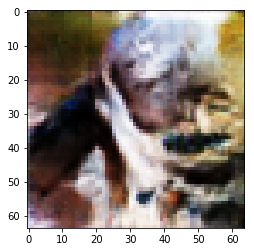

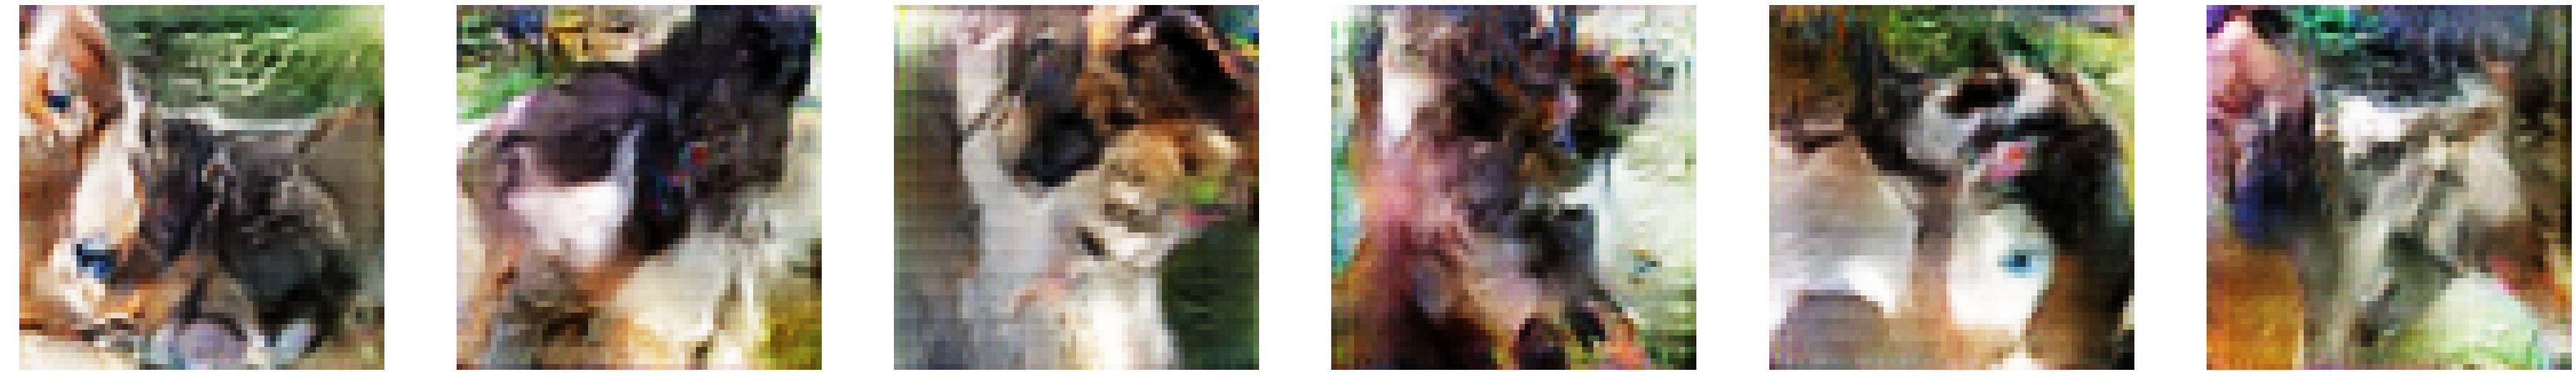

loss=rals 1epochの中での平均値 
 37.88s [172/301] Loss_D: 0.0557 Loss_G: 3.0063 outputR: 0.1040 outputF: -0.7291 / -0.7527
  最後のバッチのloss等 
    37.88s [172/301] Loss_D: 0.0662 Loss_G: 2.8601 outputR: 0.2697 outputF: -0.6004 / -0.5834
loss=rals 1epochの中での平均値 
 37.99s [173/301] Loss_D: 0.0553 Loss_G: 3.0003 outputR: 0.1002 outputF: -0.7329 / -0.7567
  最後のバッチのloss等 
    37.99s [173/301] Loss_D: 0.0136 Loss_G: 3.4127 outputR: 0.1008 outputF: -0.8865 / -0.8503
loss=rals 1epochの中での平均値 
 38.24s [174/301] Loss_D: 0.0547 Loss_G: 3.0107 outputR: 0.1628 outputF: -0.6720 / -0.6947
  最後のバッチのloss等 
    38.24s [174/301] Loss_D: 0.0900 Loss_G: 2.6199 outputR: 0.0943 outputF: -0.5078 / -0.6294
loss=rals 1epochの中での平均値 
 38.04s [175/301] Loss_D: 0.0533 Loss_G: 2.9972 outputR: 0.1476 outputF: -0.6881 / -0.7094
  最後のバッチのloss等 
    38.05s [175/301] Loss_D: 0.0618 Loss_G: 2.3017 outputR: -0.1921 outputF: -0.8749 / -0.8497
loss=rals 1epochの中での平均値 
 37.83s [176/301] Loss_D: 0.0559 Loss_G: 3.0043 outputR: 0.2010 output

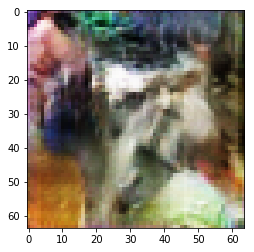

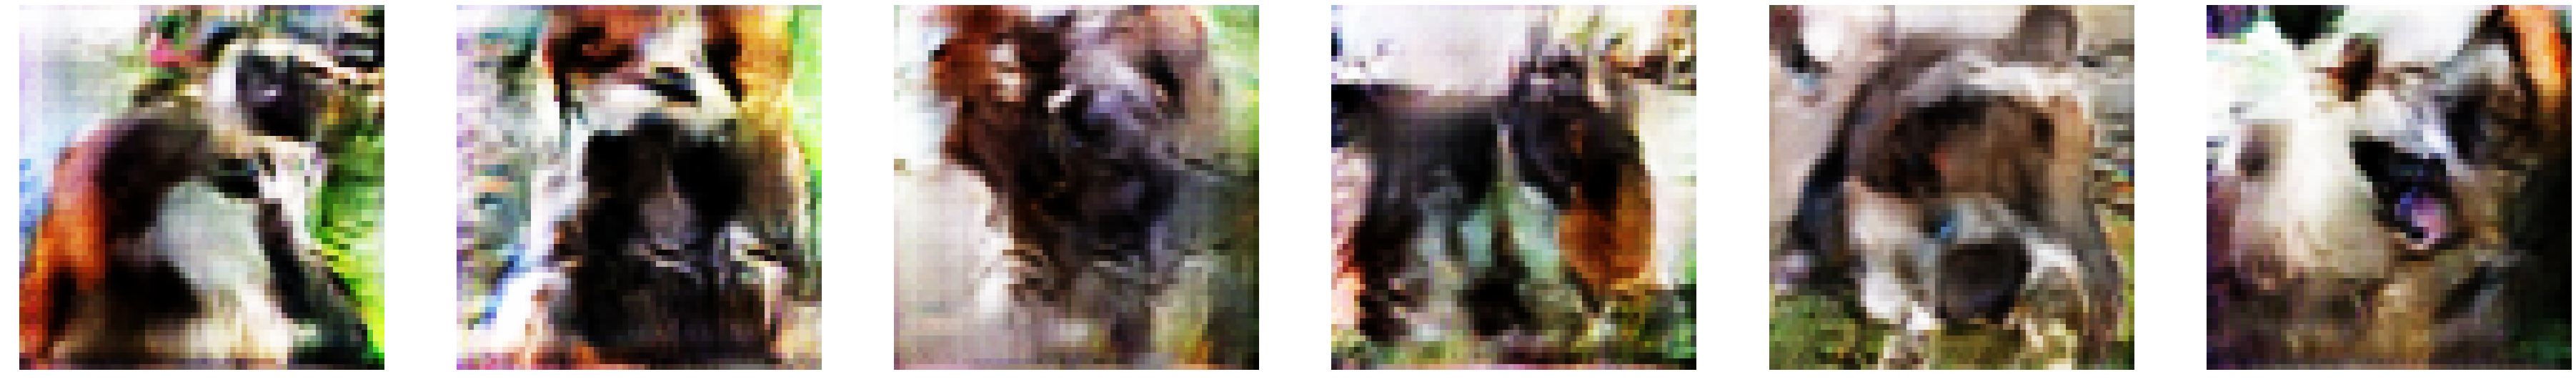

loss=rals 1epochの中での平均値 
 38.06s [182/301] Loss_D: 0.0492 Loss_G: 2.9863 outputR: 0.2291 outputF: -0.6110 / -0.6241
  最後のバッチのloss等 
    38.06s [182/301] Loss_D: 0.0331 Loss_G: 2.8888 outputR: 0.2913 outputF: -0.5231 / -0.5257
loss=rals 1epochの中での平均値 
 38.00s [183/301] Loss_D: 0.0491 Loss_G: 2.9894 outputR: 0.2324 outputF: -0.6082 / -0.6214
  最後のバッチのloss等 
    38.00s [183/301] Loss_D: 0.1598 Loss_G: 3.8396 outputR: 0.3724 outputF: -0.7650 / -0.7419
loss=rals 1epochの中での平均値 
 38.05s [184/301] Loss_D: 0.0511 Loss_G: 2.9815 outputR: 0.2503 outputF: -0.5883 / -0.6033
  最後のバッチのloss等 
    38.05s [184/301] Loss_D: 0.0559 Loss_G: 2.7399 outputR: 0.2109 outputF: -0.6064 / -0.6054
loss=rals 1epochの中での平均値 
 37.96s [185/301] Loss_D: 0.0499 Loss_G: 2.9966 outputR: 0.2054 outputF: -0.6336 / -0.6509
  最後のバッチのloss等 
    37.96s [185/301] Loss_D: 0.0119 Loss_G: 3.4949 outputR: 0.3160 outputF: -0.6755 / -0.6564
loss=rals 1epochの中での平均値 
 38.25s [186/301] Loss_D: 0.0527 Loss_G: 2.9875 outputR: 0.2206 outputF

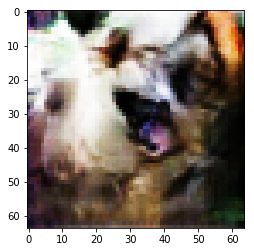

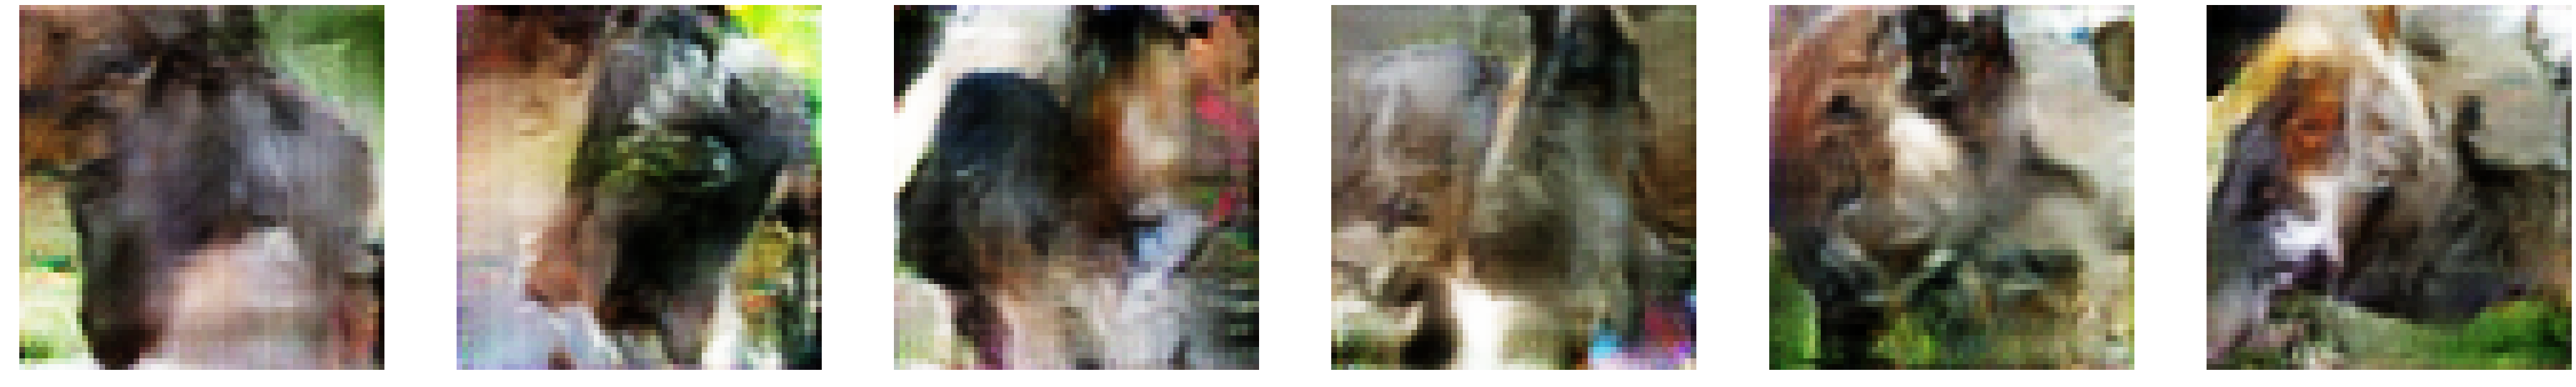

loss=rals 1epochの中での平均値 
 38.04s [192/301] Loss_D: 0.0518 Loss_G: 3.0141 outputR: 0.2999 outputF: -0.5369 / -0.5594
  最後のバッチのloss等 
    38.04s [192/301] Loss_D: 0.0192 Loss_G: 2.9448 outputR: 0.4868 outputF: -0.3118 / -0.3339
loss=rals 1epochの中での平均値 
 37.86s [193/301] Loss_D: 0.0527 Loss_G: 3.0022 outputR: 0.3223 outputF: -0.5154 / -0.5359
  最後のバッチのloss等 
    37.86s [193/301] Loss_D: 0.0281 Loss_G: 3.1904 outputR: 0.4993 outputF: -0.3941 / -0.3977
loss=rals 1epochの中での平均値 
 38.19s [194/301] Loss_D: 0.0482 Loss_G: 3.0088 outputR: 0.3681 outputF: -0.4747 / -0.4907
  最後のバッチのloss等 
    38.19s [194/301] Loss_D: 0.0451 Loss_G: 3.2324 outputR: 0.4965 outputF: -0.2540 / -0.4227
loss=rals 1epochの中での平均値 
 37.93s [195/301] Loss_D: 0.0523 Loss_G: 3.0030 outputR: 0.3405 outputF: -0.4966 / -0.5181
  最後のバッチのloss等 
    37.93s [195/301] Loss_D: 0.0440 Loss_G: 2.8373 outputR: 0.5171 outputF: -0.3058 / -0.2997
loss=rals 1epochの中での平均値 
 38.07s [196/301] Loss_D: 0.0442 Loss_G: 3.0026 outputR: 0.4098 outputF

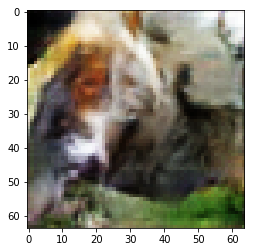

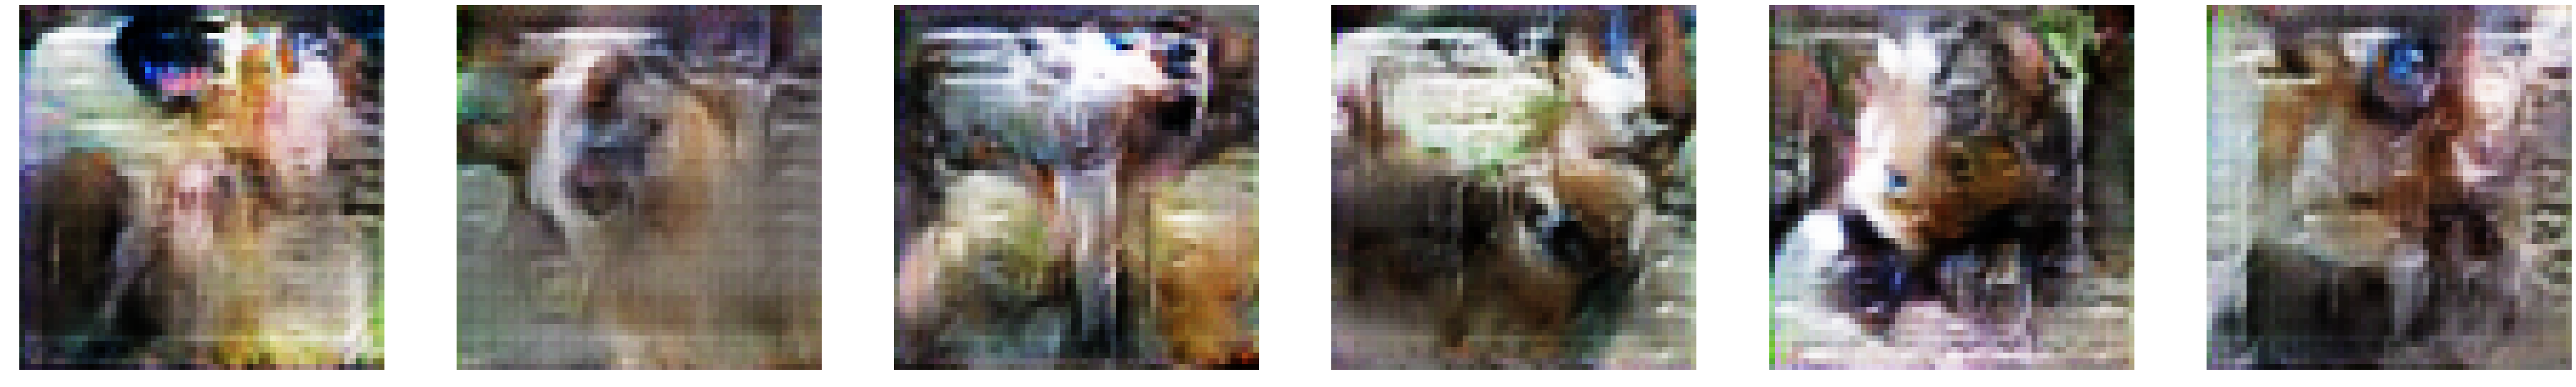

loss=rals 1epochの中での平均値 
 38.19s [202/301] Loss_D: 0.0456 Loss_G: 3.0123 outputR: 0.4173 outputF: -0.4280 / -0.4429
  最後のバッチのloss等 
    38.19s [202/301] Loss_D: 0.0033 Loss_G: 3.1773 outputR: 0.3462 outputF: -0.5302 / -0.5307
loss=rals 1epochの中での平均値 
 38.05s [203/301] Loss_D: 0.0525 Loss_G: 2.9814 outputR: 0.3320 outputF: -0.5012 / -0.5218
  最後のバッチのloss等 
    38.05s [203/301] Loss_D: 0.0655 Loss_G: 3.1501 outputR: 0.1599 outputF: -0.7790 / -0.7691
loss=rals 1epochの中での平均値 
 38.01s [204/301] Loss_D: 0.0465 Loss_G: 3.0109 outputR: 0.3799 outputF: -0.4640 / -0.4802
  最後のバッチのloss等 
    38.01s [204/301] Loss_D: 0.0430 Loss_G: 2.9525 outputR: 0.2810 outputF: -0.5609 / -0.5731
loss=rals 1epochの中での平均値 
 38.23s [205/301] Loss_D: 0.0486 Loss_G: 3.0094 outputR: 0.3768 outputF: -0.4661 / -0.4825
  最後のバッチのloss等 
    38.23s [205/301] Loss_D: 0.0606 Loss_G: 2.8102 outputR: 0.5629 outputF: -0.2602 / -0.2679
loss=rals 1epochの中での平均値 
 37.97s [206/301] Loss_D: 0.0494 Loss_G: 3.0138 outputR: 0.4008 outputF

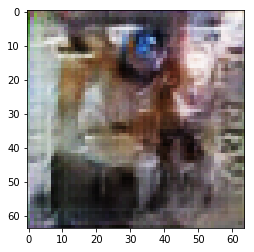

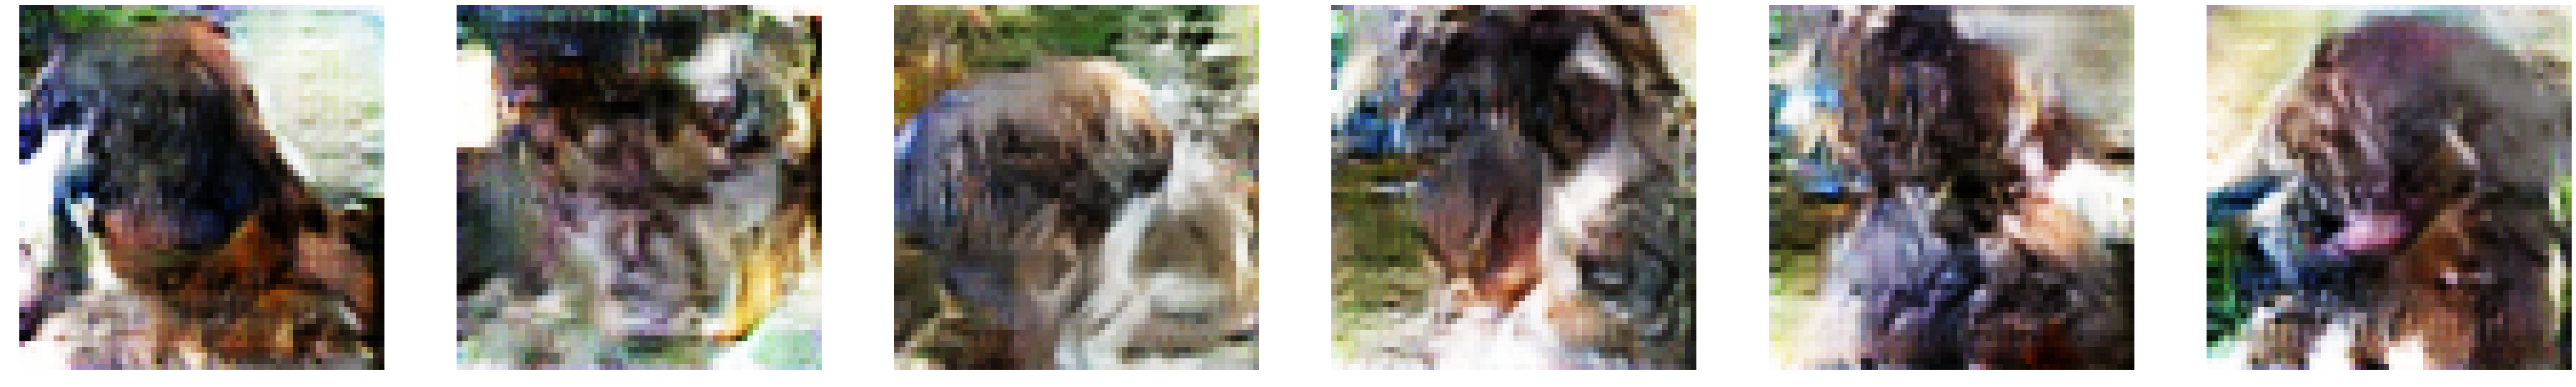

loss=rals 1epochの中での平均値 
 37.60s [212/301] Loss_D: 0.0409 Loss_G: 2.9974 outputR: 0.4562 outputF: -0.3948 / -0.4021
  最後のバッチのloss等 
    37.60s [212/301] Loss_D: 0.0208 Loss_G: 2.9753 outputR: 0.4043 outputF: -0.4272 / -0.4350
loss=rals 1epochの中での平均値 
 37.81s [213/301] Loss_D: 0.0420 Loss_G: 3.0120 outputR: 0.4231 outputF: -0.4249 / -0.4374
  最後のバッチのloss等 
    37.81s [213/301] Loss_D: 0.0238 Loss_G: 3.0307 outputR: 0.4128 outputF: -0.4494 / -0.4515
loss=rals 1epochの中での平均値 
 37.54s [214/301] Loss_D: 0.0395 Loss_G: 3.0175 outputR: 0.4544 outputF: -0.3988 / -0.4072
  最後のバッチのloss等 
    37.54s [214/301] Loss_D: 0.0649 Loss_G: 3.0905 outputR: 0.4587 outputF: -0.4661 / -0.4616
loss=rals 1epochの中での平均値 
 37.65s [215/301] Loss_D: 0.0479 Loss_G: 2.9975 outputR: 0.4119 outputF: -0.4261 / -0.4451
  最後のバッチのloss等 
    37.65s [215/301] Loss_D: 0.0234 Loss_G: 2.8950 outputR: 0.3724 outputF: -0.4500 / -0.4510
loss=rals 1epochの中での平均値 
 37.58s [216/301] Loss_D: 0.0428 Loss_G: 3.0116 outputR: 0.4581 outputF

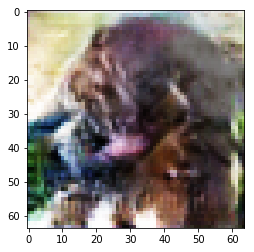

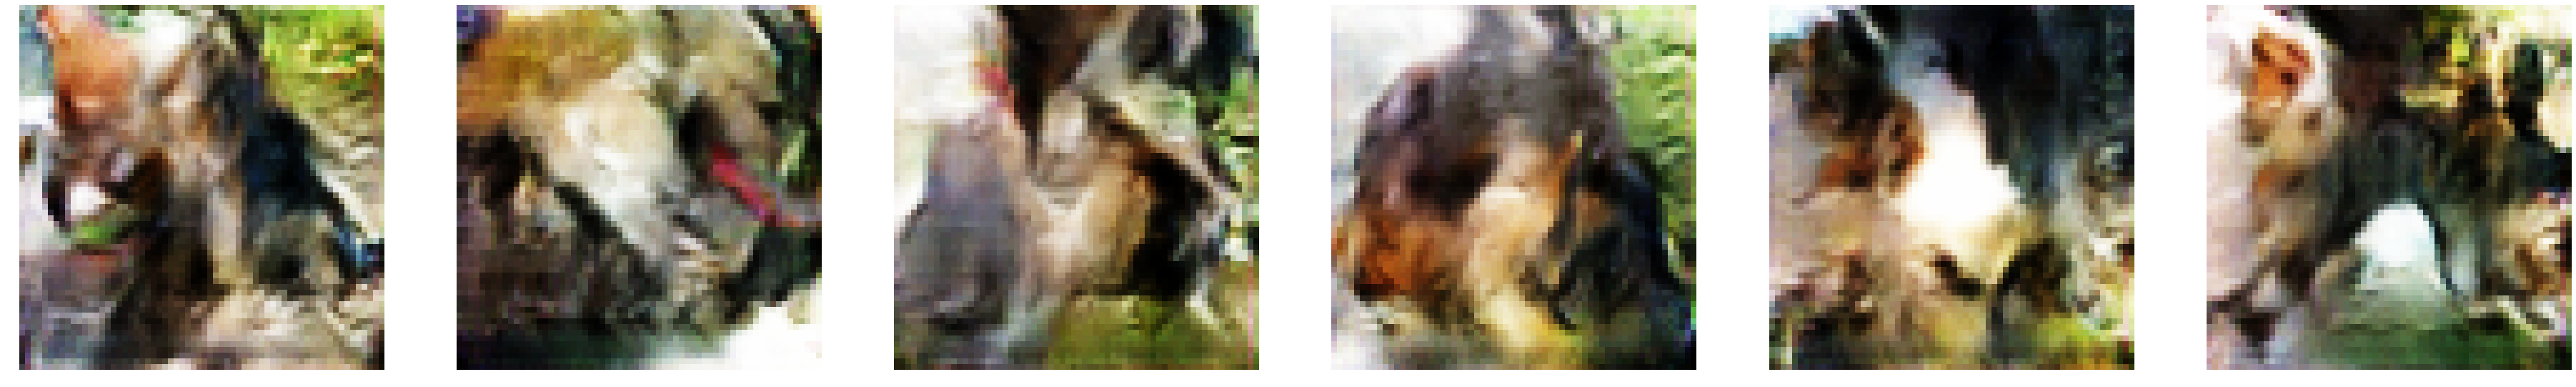

loss=rals 1epochの中での平均値 
 37.70s [222/301] Loss_D: 0.0414 Loss_G: 3.0102 outputR: 0.5271 outputF: -0.3229 / -0.3345
  最後のバッチのloss等 
    37.70s [222/301] Loss_D: 0.0207 Loss_G: 3.1108 outputR: 0.3910 outputF: -0.4925 / -0.4898
loss=rals 1epochの中での平均値 
 37.58s [223/301] Loss_D: 0.0480 Loss_G: 3.0148 outputR: 0.4687 outputF: -0.3702 / -0.3929
  最後のバッチのloss等 
    37.58s [223/301] Loss_D: 0.0506 Loss_G: 3.0176 outputR: 0.6156 outputF: -0.1738 / -0.2569
loss=rals 1epochの中での平均値 
 37.64s [224/301] Loss_D: 0.0486 Loss_G: 3.0230 outputR: 0.4321 outputF: -0.4074 / -0.4307
  最後のバッチのloss等 
    37.64s [224/301] Loss_D: 0.0587 Loss_G: 2.6728 outputR: 0.2676 outputF: -0.5218 / -0.5174
loss=rals 1epochの中での平均値 
 37.59s [225/301] Loss_D: 0.0447 Loss_G: 3.0239 outputR: 0.5032 outputF: -0.3450 / -0.3608
  最後のバッチのloss等 
    37.59s [225/301] Loss_D: 0.0292 Loss_G: 3.3173 outputR: 0.7503 outputF: -0.1869 / -0.1862
loss=rals 1epochの中での平均値 
 37.58s [226/301] Loss_D: 0.0400 Loss_G: 2.9993 outputR: 0.5303 outputF

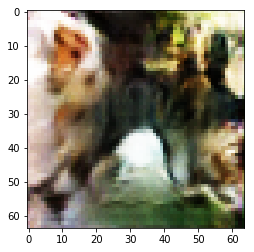

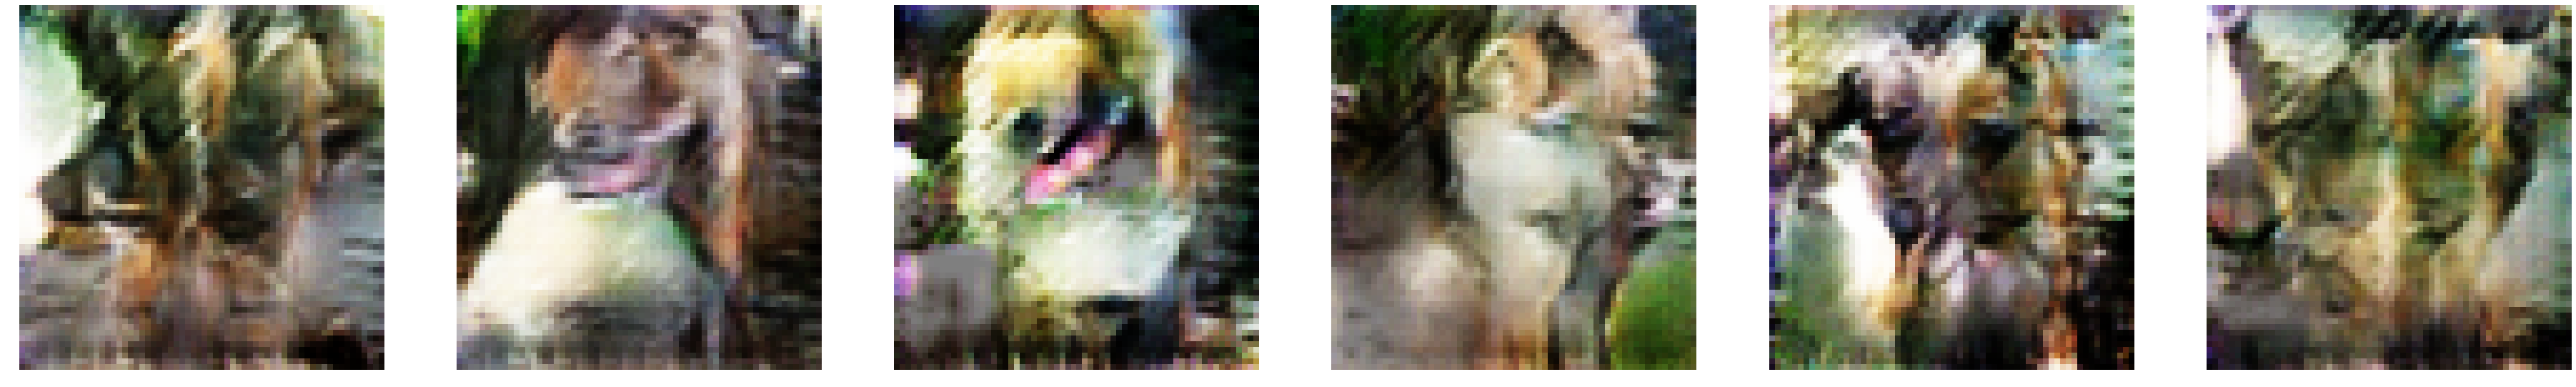

loss=rals 1epochの中での平均値 
 37.67s [232/301] Loss_D: 0.0412 Loss_G: 3.0169 outputR: 0.5330 outputF: -0.3179 / -0.3298
  最後のバッチのloss等 
    37.67s [232/301] Loss_D: 0.0622 Loss_G: 2.9917 outputR: 0.5483 outputF: -0.3514 / -0.3508
loss=rals 1epochの中での平均値 
 37.52s [233/301] Loss_D: 0.0450 Loss_G: 3.0048 outputR: 0.4855 outputF: -0.3571 / -0.3740
  最後のバッチのloss等 
    37.52s [233/301] Loss_D: 0.0156 Loss_G: 2.9675 outputR: 0.2836 outputF: -0.5139 / -0.5236
loss=rals 1epochの中での平均値 
 37.59s [234/301] Loss_D: 0.0424 Loss_G: 3.0144 outputR: 0.4976 outputF: -0.3517 / -0.3639
  最後のバッチのloss等 
    37.59s [234/301] Loss_D: 0.0301 Loss_G: 3.3834 outputR: 0.6202 outputF: -0.3428 / -0.3324
loss=rals 1epochの中での平均値 
 37.65s [235/301] Loss_D: 0.0384 Loss_G: 3.0068 outputR: 0.5415 outputF: -0.3125 / -0.3195
  最後のバッチのloss等 
    37.65s [235/301] Loss_D: 0.0042 Loss_G: 3.1125 outputR: 0.5643 outputF: -0.2937 / -0.2944
loss=rals 1epochの中での平均値 
 37.54s [236/301] Loss_D: 0.0493 Loss_G: 3.0092 outputR: 0.4893 outputF

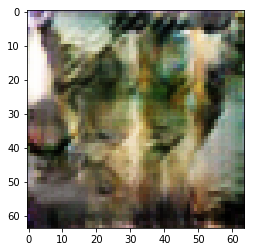

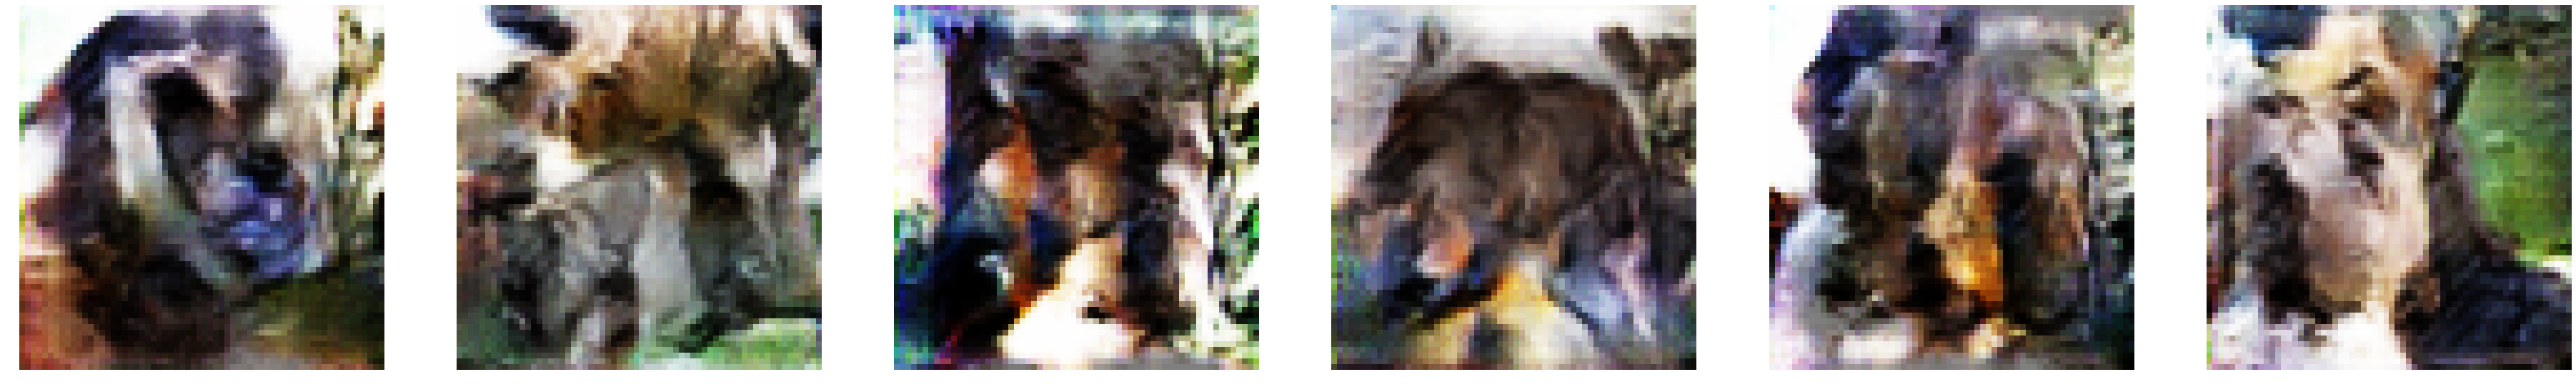

loss=rals 1epochの中での平均値 
 37.54s [242/301] Loss_D: 0.0412 Loss_G: 2.9989 outputR: 0.5498 outputF: -0.2981 / -0.3100
  最後のバッチのloss等 
    37.54s [242/301] Loss_D: 0.1612 Loss_G: 2.2573 outputR: 0.1358 outputF: -0.3656 / -0.4829
loss=rals 1epochの中での平均値 
 37.71s [243/301] Loss_D: 0.0437 Loss_G: 2.9937 outputR: 0.5249 outputF: -0.3194 / -0.3325
  最後のバッチのloss等 
    37.71s [243/301] Loss_D: 0.0202 Loss_G: 3.0989 outputR: 0.5832 outputF: -0.2981 / -0.2967
loss=rals 1epochの中での平均値 
 37.53s [244/301] Loss_D: 0.0394 Loss_G: 2.9973 outputR: 0.6010 outputF: -0.2514 / -0.2577
  最後のバッチのloss等 
    37.53s [244/301] Loss_D: 0.0201 Loss_G: 3.1054 outputR: 0.6676 outputF: -0.2180 / -0.2167
loss=rals 1epochの中での平均値 
 37.73s [245/301] Loss_D: 0.0390 Loss_G: 3.0008 outputR: 0.5979 outputF: -0.2538 / -0.2622
  最後のバッチのloss等 
    37.73s [245/301] Loss_D: 0.0336 Loss_G: 2.7878 outputR: 0.6878 outputF: -0.0802 / -0.0978
loss=rals 1epochの中での平均値 
 37.53s [246/301] Loss_D: 0.0389 Loss_G: 3.0055 outputR: 0.6054 outputF

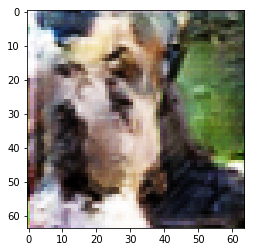

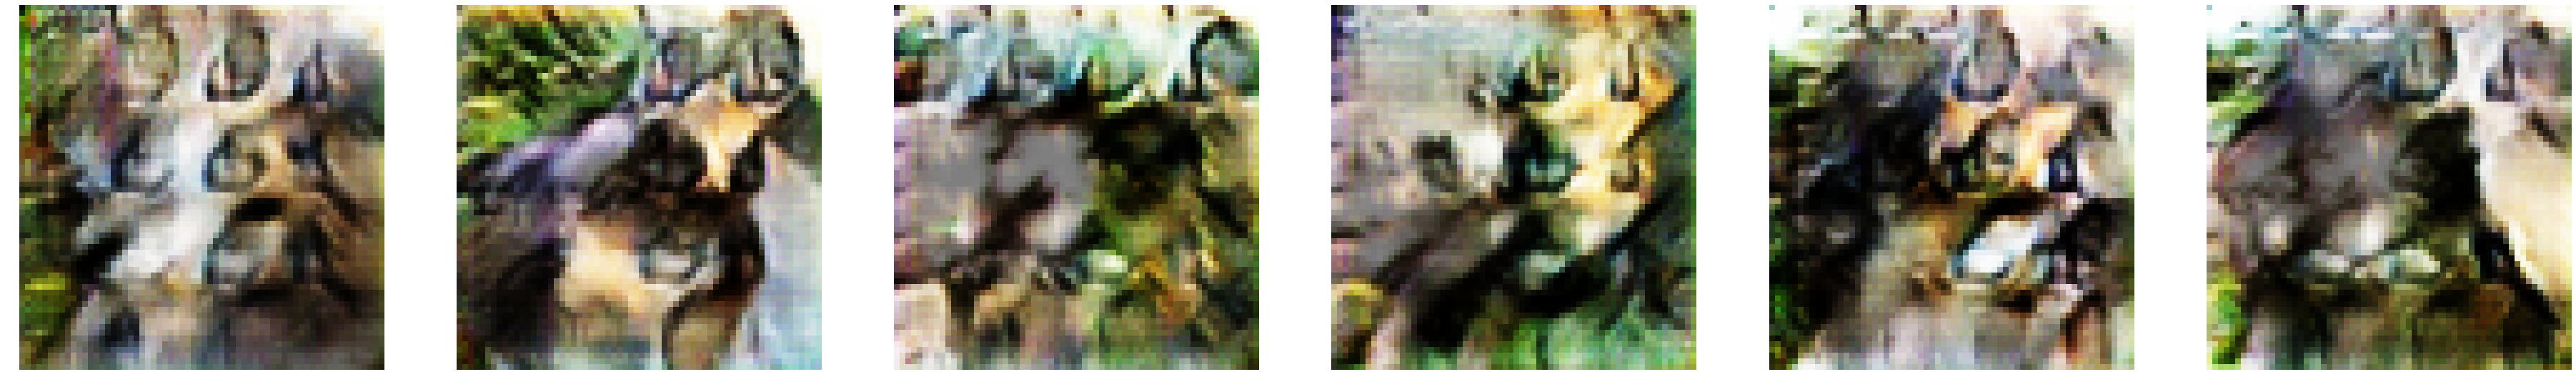

loss=rals 1epochの中での平均値 
 37.50s [252/301] Loss_D: 0.0432 Loss_G: 3.0340 outputR: 0.5511 outputF: -0.2933 / -0.3168
  最後のバッチのloss等 
    37.50s [252/301] Loss_D: 0.0619 Loss_G: 2.5298 outputR: 0.4271 outputF: -0.3340 / -0.3176
loss=rals 1epochの中での平均値 
 37.76s [253/301] Loss_D: 0.0433 Loss_G: 3.0183 outputR: 0.6054 outputF: -0.2410 / -0.2586
  最後のバッチのloss等 
    37.76s [253/301] Loss_D: 0.2103 Loss_G: 4.1929 outputR: 0.8434 outputF: 0.3846 / -0.3079
loss=rals 1epochの中での平均値 
 37.68s [254/301] Loss_D: 0.0406 Loss_G: 3.0104 outputR: 0.6241 outputF: -0.2270 / -0.2379
  最後のバッチのloss等 
    37.68s [254/301] Loss_D: 0.0635 Loss_G: 3.1327 outputR: 0.6704 outputF: -0.2576 / -0.2517
loss=rals 1epochの中での平均値 
 37.54s [255/301] Loss_D: 0.0391 Loss_G: 3.0219 outputR: 0.6041 outputF: -0.2481 / -0.2605
  最後のバッチのloss等 
    37.54s [255/301] Loss_D: 0.0404 Loss_G: 2.7369 outputR: 0.5668 outputF: -0.2229 / -0.2250
loss=rals 1epochの中での平均値 
 37.54s [256/301] Loss_D: 0.0384 Loss_G: 3.0104 outputR: 0.6005 outputF:

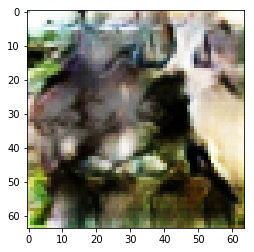

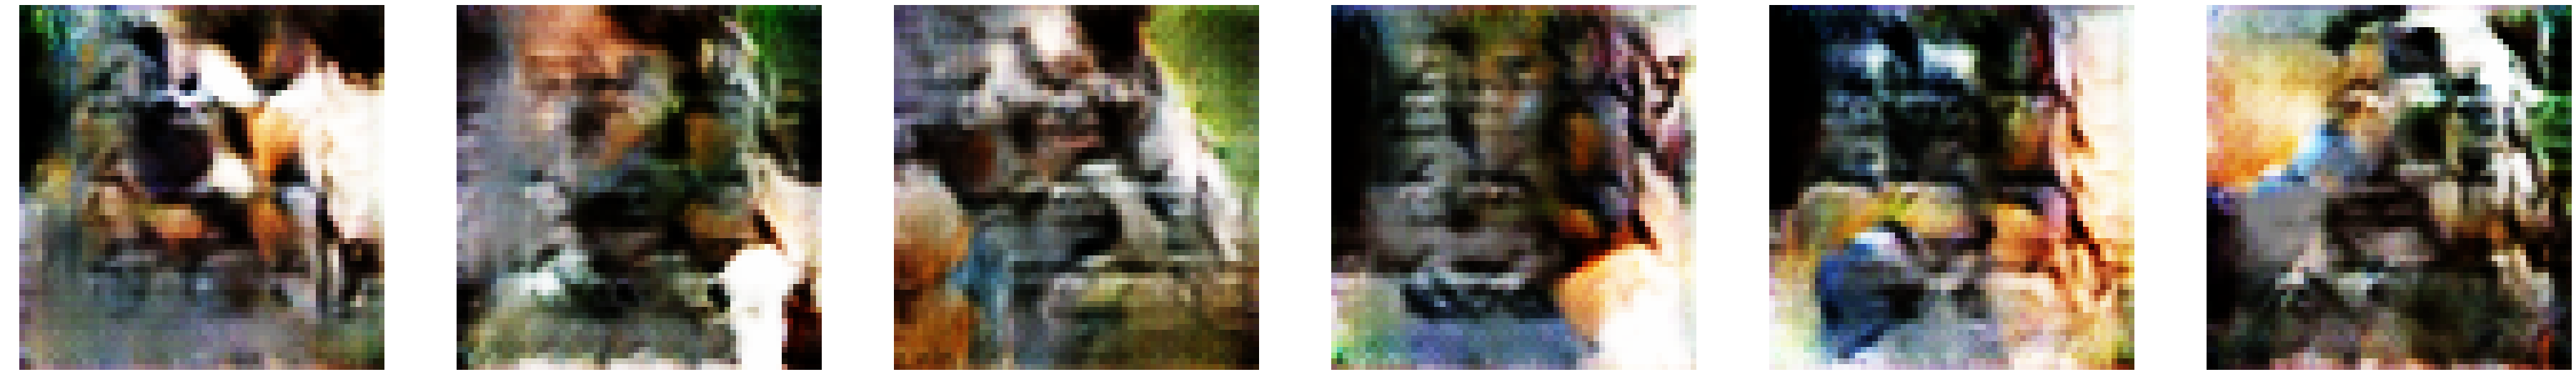

loss=rals 1epochの中での平均値 
 37.58s [262/301] Loss_D: 0.0438 Loss_G: 3.0082 outputR: 0.6000 outputF: -0.2449 / -0.2615
  最後のバッチのloss等 
    37.58s [262/301] Loss_D: 0.0047 Loss_G: 3.3099 outputR: 0.4960 outputF: -0.4232 / -0.4210
loss=rals 1epochの中での平均値 
 37.64s [263/301] Loss_D: 0.0401 Loss_G: 3.0192 outputR: 0.6319 outputF: -0.2200 / -0.2316
  最後のバッチのloss等 
    37.64s [263/301] Loss_D: 0.0390 Loss_G: 2.8269 outputR: 0.5526 outputF: -0.2676 / -0.2667
loss=rals 1epochの中での平均値 
 37.59s [264/301] Loss_D: 0.0370 Loss_G: 3.0096 outputR: 0.6330 outputF: -0.2220 / -0.2293
  最後のバッチのloss等 
    37.59s [264/301] Loss_D: 0.0017 Loss_G: 3.2537 outputR: 0.6888 outputF: -0.2158 / -0.2135
loss=rals 1epochの中での平均値 
 37.54s [265/301] Loss_D: 0.0392 Loss_G: 3.0242 outputR: 0.6261 outputF: -0.2242 / -0.2390
  最後のバッチのloss等 
    37.54s [265/301] Loss_D: 0.0440 Loss_G: 2.8957 outputR: 0.4135 outputF: -0.4253 / -0.4262
loss=rals 1epochの中での平均値 
 37.57s [266/301] Loss_D: 0.0437 Loss_G: 3.0237 outputR: 0.6045 outputF

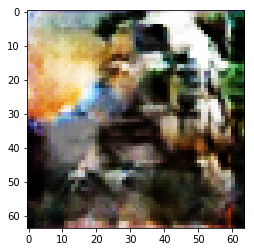

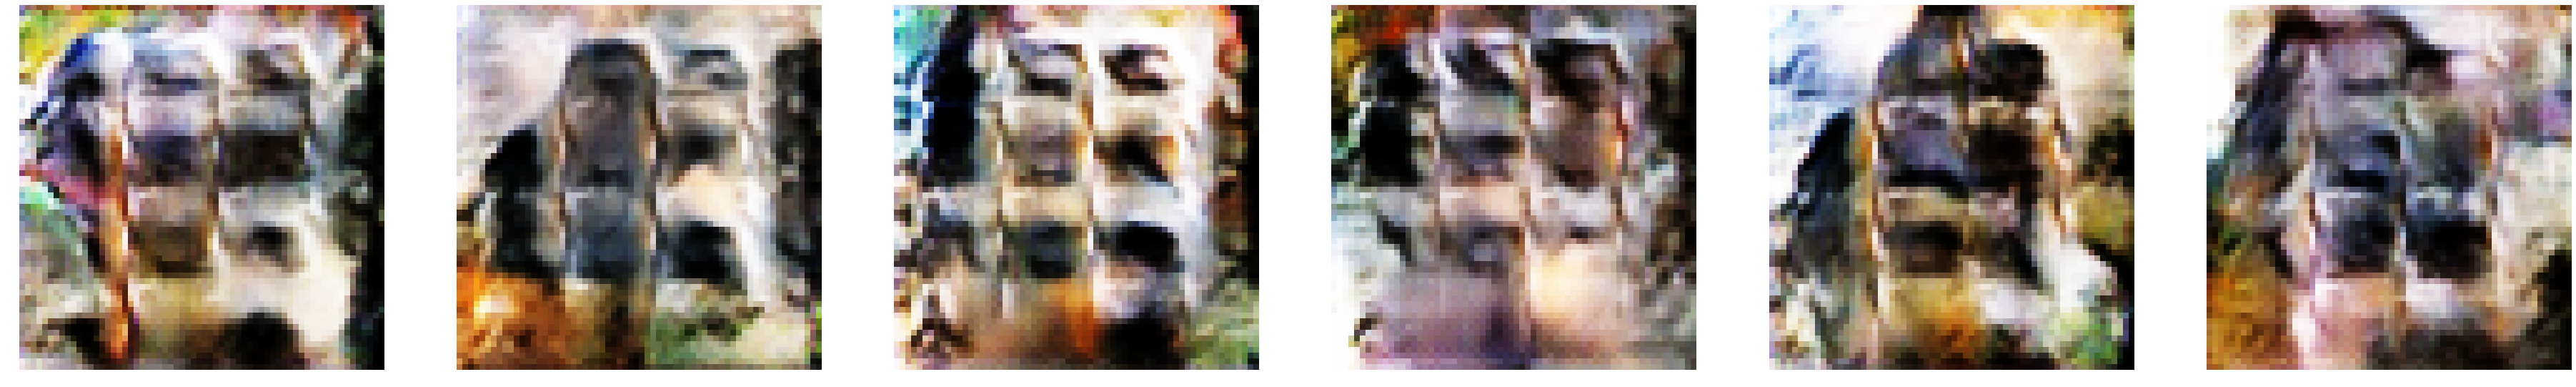

loss=rals 1epochの中での平均値 
 37.53s [272/301] Loss_D: 0.0353 Loss_G: 3.0056 outputR: 0.7108 outputF: -0.1466 / -0.1514
  最後のバッチのloss等 
    37.53s [272/301] Loss_D: 0.0215 Loss_G: 3.0146 outputR: 0.7533 outputF: -0.1070 / -0.1069
loss=rals 1epochの中での平均値 
 37.59s [273/301] Loss_D: 0.0393 Loss_G: 3.0038 outputR: 0.6970 outputF: -0.1538 / -0.1647
  最後のバッチのloss等 
    37.59s [273/301] Loss_D: 0.0019 Loss_G: 3.2074 outputR: 0.7060 outputF: -0.1928 / -0.1915
loss=rals 1epochの中での平均値 
 37.44s [274/301] Loss_D: 0.0369 Loss_G: 3.0094 outputR: 0.6722 outputF: -0.1821 / -0.1899
  最後のバッチのloss等 
    37.44s [274/301] Loss_D: 0.0219 Loss_G: 3.1870 outputR: 0.7709 outputF: -0.1305 / -0.1308
loss=rals 1epochの中での平均値 
 37.55s [275/301] Loss_D: 0.0368 Loss_G: 3.0057 outputR: 0.7026 outputF: -0.1514 / -0.1590
  最後のバッチのloss等 
    37.55s [275/301] Loss_D: 0.0592 Loss_G: 2.6703 outputR: 0.7311 outputF: -0.0459 / -0.0622
loss=rals 1epochの中での平均値 
 37.65s [276/301] Loss_D: 0.0386 Loss_G: 3.0123 outputR: 0.6634 outputF

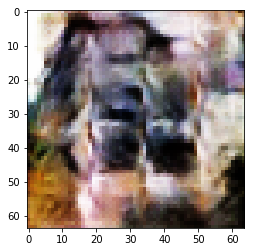

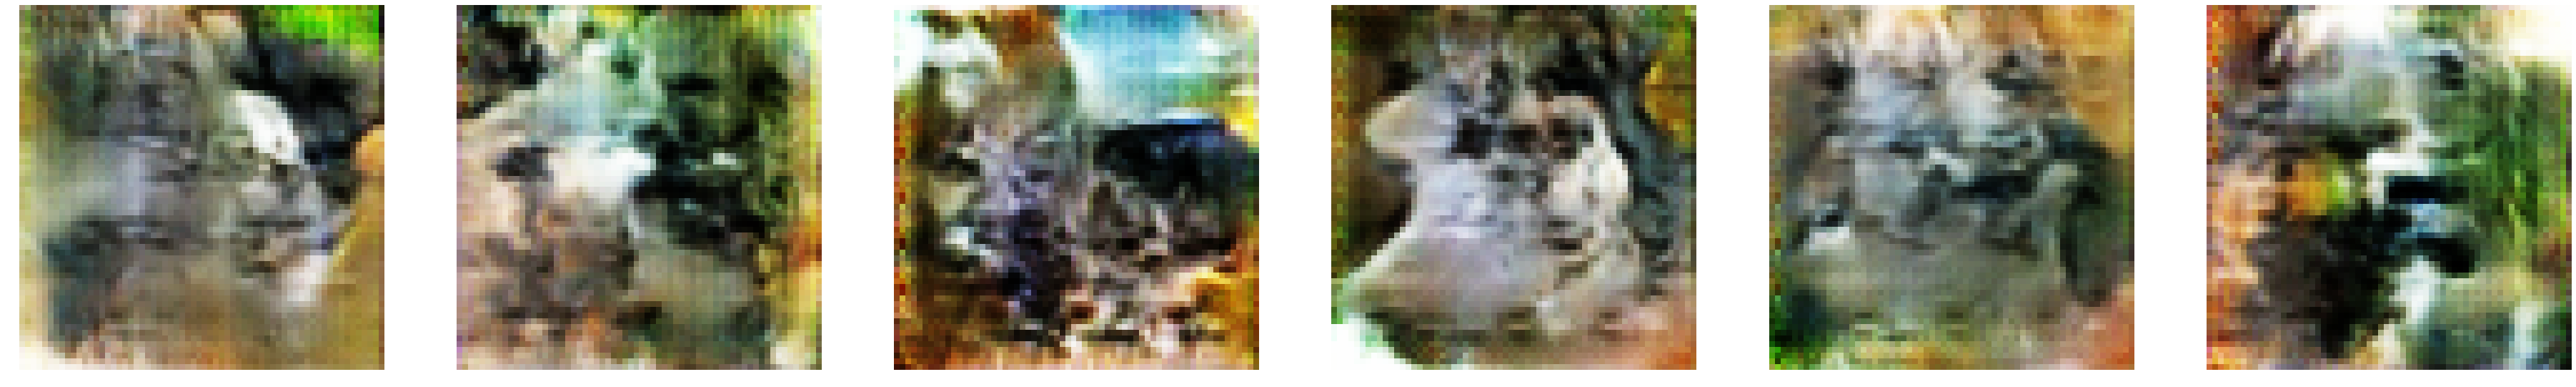

loss=rals 1epochの中での平均値 
 37.52s [282/301] Loss_D: 0.0366 Loss_G: 3.0075 outputR: 0.7076 outputF: -0.1476 / -0.1546
  最後のバッチのloss等 
    37.52s [282/301] Loss_D: 0.0398 Loss_G: 3.0331 outputR: 0.6192 outputF: -0.2632 / -0.2611
loss=rals 1epochの中での平均値 
 37.55s [283/301] Loss_D: 0.0351 Loss_G: 3.0206 outputR: 0.7503 outputF: -0.1080 / -0.1144
  最後のバッチのloss等 
    37.55s [283/301] Loss_D: 0.0557 Loss_G: 2.6951 outputR: 0.6508 outputF: -0.1672 / -0.1569
loss=rals 1epochの中での平均値 
 37.64s [284/301] Loss_D: 0.0433 Loss_G: 3.0283 outputR: 0.6523 outputF: -0.1920 / -0.2163
  最後のバッチのloss等 
    37.64s [284/301] Loss_D: 0.1020 Loss_G: 2.8032 outputR: 0.3626 outputF: -0.2501 / -0.4349
loss=rals 1epochの中での平均値 
 37.80s [285/301] Loss_D: 0.0460 Loss_G: 3.0228 outputR: 0.6246 outputF: -0.2169 / -0.2413
  最後のバッチのloss等 
    37.81s [285/301] Loss_D: 0.0544 Loss_G: 2.9033 outputR: 0.7166 outputF: -0.0092 / -0.1311
loss=rals 1epochの中での平均値 
 37.46s [286/301] Loss_D: 0.0389 Loss_G: 3.0071 outputR: 0.6495 outputF

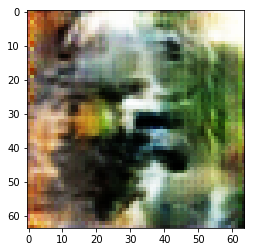

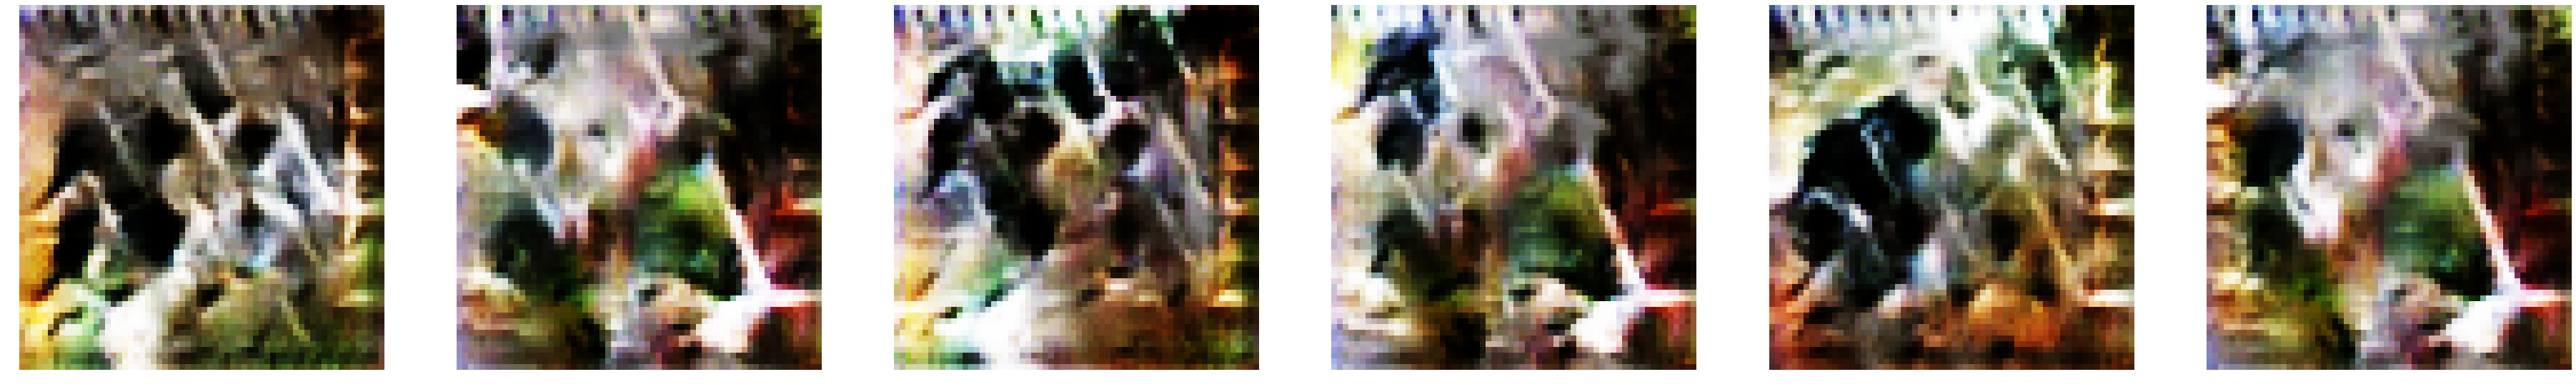

loss=rals 1epochの中での平均値 
 37.76s [292/301] Loss_D: 0.0363 Loss_G: 3.0355 outputR: 0.6898 outputF: -0.1652 / -0.1783
  最後のバッチのloss等 
    37.76s [292/301] Loss_D: 0.0591 Loss_G: 3.0259 outputR: 0.7645 outputF: -0.1240 / -0.1250
loss=rals 1epochの中での平均値 
 37.84s [293/301] Loss_D: 0.0373 Loss_G: 3.0232 outputR: 0.6866 outputF: -0.1678 / -0.1791
  最後のバッチのloss等 
    37.84s [293/301] Loss_D: 0.0641 Loss_G: 2.9834 outputR: 0.7016 outputF: -0.1747 / -0.1782
loss=rals 1epochの中での平均値 
 37.63s [294/301] Loss_D: 0.0390 Loss_G: 3.0425 outputR: 0.6277 outputF: -0.2177 / -0.2428
  最後のバッチのloss等 
    37.63s [294/301] Loss_D: 0.0520 Loss_G: 2.8536 outputR: 0.3959 outputF: -0.3836 / -0.4326
loss=rals 1epochの中での平均値 
 37.67s [295/301] Loss_D: 0.0431 Loss_G: 3.0334 outputR: 0.6667 outputF: -0.1807 / -0.2002
  最後のバッチのloss等 
    37.67s [295/301] Loss_D: 0.0473 Loss_G: 2.8177 outputR: 0.7580 outputF: -0.0458 / -0.0477
loss=rals 1epochの中での平均値 
 37.63s [296/301] Loss_D: 0.0384 Loss_G: 3.0256 outputR: 0.7399 outputF

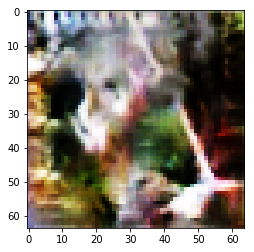

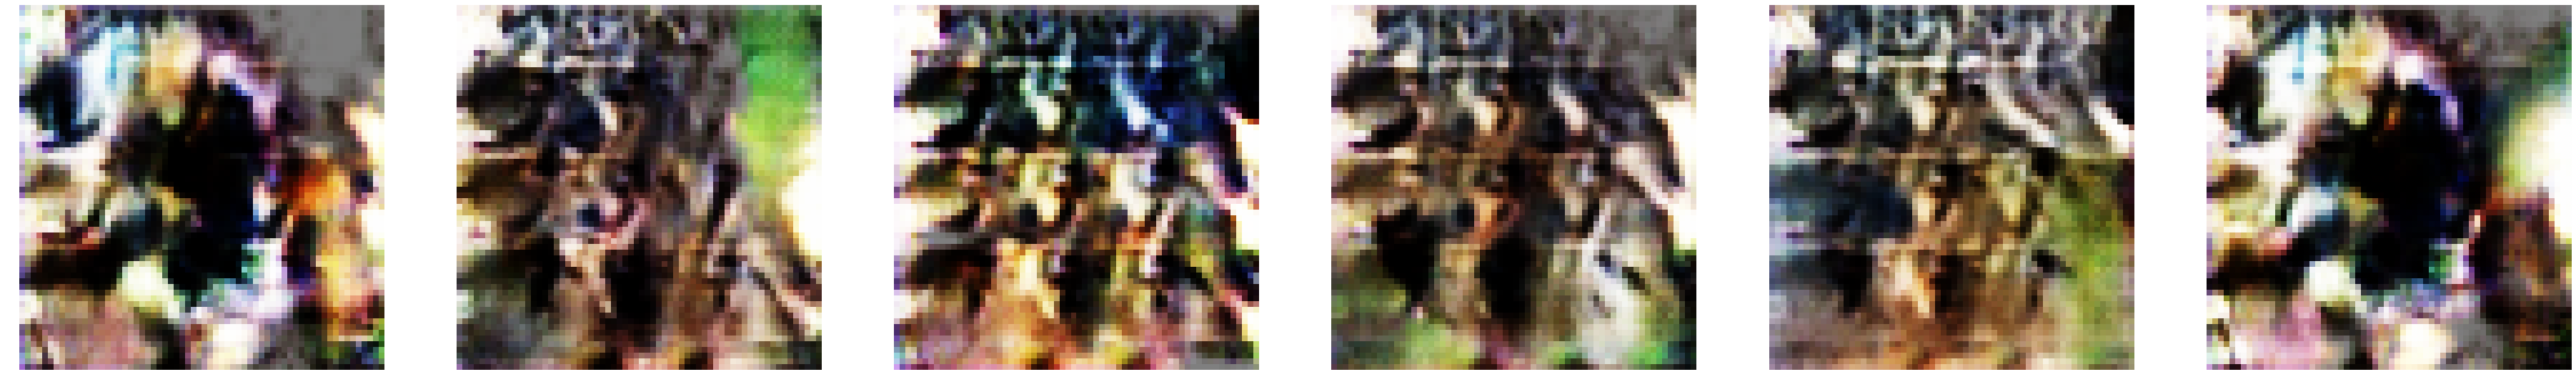

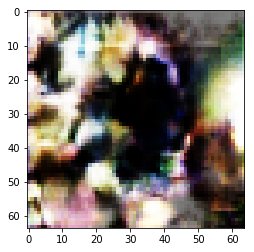

In [11]:
torch.backends.cudnn.benchmark = True

d_loss_log = []
g_loss_log = []
dout_real_log = []
dout_fake_log = []
dout_fake_log2 = []

iter_n = len(train_loader) - 1 #最後の余ったバッチは計算されないから-1

for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # epochの損失和
    epoch_d_loss = 0.0  # epochの損失和
    epoch_dout_real = 0.0
    epoch_dout_fake = 0.0
    epoch_dout_fake2 = 0.0

    epoch_time = time.perf_counter()
    if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!"); break

    for ii, (real_images, dog_labels) in enumerate(train_loader):
        if real_images.shape[0]!= BATCH_SIZE: continue
        
        # ラベルにノイズを入れる。そして時々fakeとrealを入れ替える。
        if use_soft_noisy_labels:
            real_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*R_uni))
            fake_labels = torch.squeeze(torch.empty((BATCH_SIZE, 1), device=device).uniform_(*F_uni))
            for p in np.random.choice(BATCH_SIZE, size=np.random.randint((BATCH_SIZE//8)), replace=False):
                real_labels[p], fake_labels[p] = fake_labels[p], real_labels[p] # swap labels
        else:
            real_labels = torch.full((BATCH_SIZE, 1), 1.0, device=device)
            fake_labels = torch.full((BATCH_SIZE, 1), 0.0, device=device)
        
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()

        dog_labels = torch.tensor(dog_labels, device=device)
        real_images = real_images.to(device)
        noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
        
        outputR = netD((real_images, dog_labels))
        fake_images = netG((noise, dog_labels))

        outputF = netD((fake_images.detach(), dog_labels))
        if loss_calc == 'rals':
            errD = (torch.mean((outputR - torch.mean(outputF) - real_labels) ** 2) + 
                    torch.mean((outputF - torch.mean(outputR) + real_labels) ** 2))/2
            
        elif loss_calc == 'hinge':
            d_loss_real = torch.nn.ReLU()(1.0 - (outputR - torch.mean(outputF))).mean()
            d_loss_fake = torch.nn.ReLU()(1.0 + (outputF - torch.mean(outputR))).mean()
            errD = (d_loss_real + d_loss_fake) / 2

        errD.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
                                          
        outputF2 = netD((fake_images, dog_labels))
        if loss_calc == 'rals':
            errG = (torch.mean((outputR - torch.mean(outputF2) + real_labels) ** 2) +
                    torch.mean((outputF2 - torch.mean(outputR) - real_labels) ** 2)) / 2
        elif loss_calc == 'hinge':
            errG = (torch.mean(torch.nn.ReLU()(1.0 + (outputR - torch.mean(outputF2)))) + torch.mean(torch.nn.ReLU()(1.0 - (outputF2 - torch.mean(outputR)))))/2
            
        errG.backward()
        optimizerG.step()
        
        lr_schedulerG.step(epoch)
        lr_schedulerD.step(epoch)
        
        # --------------------
        # 3. 記録
        # --------------------
        epoch_d_loss += errD.item()
        epoch_g_loss += errG.item()
        epoch_dout_real += outputR.mean().item()
        epoch_dout_fake += outputF.mean().item()
        epoch_dout_fake2 += outputF2.mean().item()
        
    d_loss_log.append(epoch_d_loss/iter_n)
    g_loss_log.append(epoch_g_loss/iter_n)
    dout_real_log.append(epoch_dout_real/iter_n)
    dout_fake_log.append(epoch_dout_fake/iter_n)
    dout_fake_log2.append(epoch_dout_fake2/iter_n)
        
    if test_mode:
        print('loss=%s 1epochの中での平均値 \n %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (loss_calc,
              time.perf_counter()-epoch_time, epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] ))
        print('  最後のバッチのloss等 \n    %.2fs [%d/%d] Loss_D: %.4f Loss_G: %.4f outputR: %.4f outputF: %.4f / %.4f' % (
            time.perf_counter()-epoch_time, epoch+1, epochs, errD.item(), errG.item(),outputR.mean().item(), outputF.mean().item(),outputF2.mean().item() ))
        if epoch > 3:
            if (d_loss_log[-2] < 1e-2) and (d_loss_log[-1] < 1e-2):
                notify(epoch)
                continue
                
    if epoch % 10 == 0:
        files = []
        img = show_generated_img(6)
        plt.imshow(img)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        files.append({"imageFile": buf})
        message = 'base_gan_adam_ralsの訓練状況を伝えるよ。\n\n可愛いワンちゃん出来たかな？ \n [%d/%d] \nL_D: %.4f \nL_G: %.4f \noutR: %.4f \noutF: %.4f / %.4f' % (epoch+1, epochs, d_loss_log[-1], g_loss_log[-1],dout_real_log[-1], dout_fake_log[-1],dout_fake_log2[-1] )
        notify(message, files[0])     

## Visualise generated results by label and submit

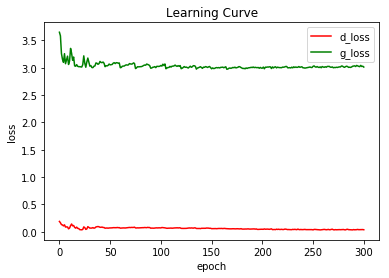

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(d_loss_log,   color="r", label="d_loss")
plt.plot(g_loss_log,   color="g", label="g_loss")

plt.legend(loc="best")

plt.show()

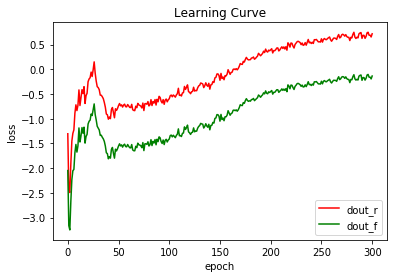

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("loss")

# Traing score と Test score をプロット
plt.plot(dout_real_log, color="r", label="dout_r")
plt.plot(dout_fake_log, color="g", label="dout_f")

plt.legend(loc="best")

plt.show()